## Problem Statement
We propose a prediction model leveraging machine learning algorithms and graph networks. By utilizing Bike Share Toronto Ridership Data and Bikeshare Toronto, both sourced from the City of Toronto's Open Data Portal, we aim to predict bike availability across stations. Our approach involves modeling the bikeshare system as a graph, employing a Graph Attention Network (GAT) with multi-headed attention, followed by LSTM layers to incorporate temporal features.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# bikeshare_availability_prediction folder link: https://drive.google.com/drive/folders/1HoEN003tbdr4V-abIpsuSDoZFAbQcDV2?usp=sharing
%cd <path to bikeshare_availability_prediction folder>

/content/drive/.shortcut-targets-by-id/1eHfo448LIm58sxpXztXwS5IHIe6Skl_A/ECE1724_Project


In [ ]:
# for example
# %cd /content/drive/.shortcut-targets-by-id/1eHfo448LIm58sxpXztXwS5IHIe6Skl_A/ECE1724_Project/Final/FinalSubmission/ece1724FinalColabNotebooks/bikeshare_availability_prediction
# bikeshare_availability_prediction is at the same level of this GAT.ipynb

/content/drive/.shortcut-targets-by-id/1eHfo448LIm58sxpXztXwS5IHIe6Skl_A/ECE1724_Project/Final/FinalSubmission/ece1724FinalColabNotebooks/bikeshare_availability_prediction


In [ ]:
! pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.1 MB/s eta 0:00:00


## Preprocessing for Graph Neural Network input

In [ ]:
import torch
import numpy as np
import pandas as pd
import os
import requests
import seaborn as sns
from geopy.distance import geodesic
from torch_geometric.data import InMemoryDataset, Data
from shutil import copyfile


from utils.math_utils import * # import evaluation metrics and z-score transformations

### Pivoting data and generating distance matrix

First let's reshape the data into a format that is suitable for training. Also generate a distance matrix to be incorporated into the model weights.

In [ ]:
# URL for station information feed
station_info_url = "https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information"
# Fetch the data from the URLs
station_info_data = requests.get(station_info_url).json()
# Convert the JSON data into Pandas DataFrames
station_info_df = pd.DataFrame(station_info_data["data"]["stations"])
station_info_df["station_id"]=station_info_df["station_id"].astype('int64')

In [ ]:
df=pd.read_csv('./dataset/bikeshare_availability_dataset.csv')
df.shape

(477648, 7)

In [ ]:
# Create a new column for row labels
df['row_label'] = df.groupby('station_id').cumcount()

# Pivot the DataFrame
pivot_df = df.pivot(index='row_label', columns='station_id', values='bikes_available')

# Reset the index if needed
pivot_df.reset_index(drop=True, inplace=True)

# Display the pivoted DataFrame
pivot_df.head()

station_id,7000,7001,7002,7003,7004,7005,7006,7007,7008,7009,...,7761,7762,7765,7766,7767,7768,7769,7770,7771,7772
0,18.0,14.0,12.0,9.0,7.0,6.0,12.0,12.0,10.0,9.0,...,10.0,8.0,7.0,8.0,8.0,6.0,7.0,8.0,12.0,6.0
1,18.0,12.0,12.0,8.0,6.0,6.0,11.0,10.0,10.0,13.0,...,10.0,6.0,7.0,8.0,8.0,6.0,7.0,8.0,12.0,6.0
2,18.0,12.0,12.0,8.0,6.0,6.0,11.0,10.0,10.0,12.0,...,10.0,7.0,7.0,8.0,8.0,6.0,7.0,8.0,12.0,6.0
3,18.0,12.0,12.0,8.0,6.0,6.0,10.0,10.0,10.0,12.0,...,10.0,7.0,7.0,8.0,8.0,6.0,7.0,8.0,12.0,6.0
4,18.0,12.0,12.0,8.0,6.0,6.0,10.0,10.0,10.0,12.0,...,10.0,7.0,7.0,8.0,8.0,6.0,7.0,8.0,12.0,6.0


There will be some stations with bike availability reaching 0 or below at some points during the day. Remove these for now as there is a physical limitation for availability not dropping below 0. This will also help to avoid exploding loss values and metrics during training, validation and evaluation.

In [ ]:
bikes_available_clean = pivot_df.drop(columns=pivot_df.columns[pivot_df.le(0).any()])
bikes_available_clean.to_csv('./dataset/bikes_available_cleaned.csv', index=False)

In [ ]:
unique_stations = df[['station_id', 'lat', 'lon']].drop_duplicates()
valid_stations = list(bikes_available_clean.columns)
unique_stations = unique_stations.loc[unique_stations['station_id'].astype(int).isin(valid_stations),:]
unique_stations.shape

(590, 3)

There are a total of 590 stations that will be used for training and creating the distance matrix.

In [ ]:
# create the distance matrix
num_stations = len(unique_stations)
distance_matrix = pd.DataFrame(index=unique_stations['station_id'], columns=unique_stations['station_id'])

# Calculate distances and fill the matrix
for i in range(num_stations):
    for j in range(num_stations):
        coord_i = (unique_stations['lat'].values[i], unique_stations['lon'].values[i])
        coord_j = (unique_stations['lat'].values[j], unique_stations['lon'].values[j])
        distance_matrix.at[unique_stations['station_id'].values[i], unique_stations['station_id'].values[j]] = geodesic(coord_i, coord_j).kilometers

In [ ]:
distance_matrix.shape

(590, 590)

In [ ]:
# saving the matrix to load in the future
distance_matrix.astype(float).to_csv('./dataset/station_distance_matrix.csv', header=None, index=None)

### Preparing Dataset and Weights

In [ ]:
import torch
from torch_geometric.loader import DataLoader

First load the saved data if available

In [ ]:
distances = pd.read_csv('./dataset/station_distance_matrix.csv', header=None).values
bikes_available = pd.read_csv('./dataset/bikes_available_cleaned.csv')

print(distances.shape)
print(bikes_available.shape)

(590, 590)
(744, 590)


In [ ]:
def distance_to_weight(W, sigma2=0.1, epsilon=0.5, gat_version=False):
    """"
    Create a weight matrix based on distances between stations
    W: distances
    sigma2: User configurable parameter to adjust sparsity of matrix
    epsilon: User configurable parameter to adjust sparsity of matrix
    gat_version: If true, use 0/1 weights with self loops.
    """
    n = W.shape[0]
    W = W
    W2, W_mask = W * W, np.ones([n, n]) - np.identity(n)
    # refer to Eq.10
    W = np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask

    # If using the gat version of this, round to 0/1 and include self loops
    if gat_version:
        W[W>0] = 1
        W += np.identity(n)

    return W

Setting up a config for training:

In [ ]:
config = {
    'BATCH_SIZE': 16,
    'EPOCHS': 300,
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 1e-3,
    'CHECKPOINT_DIR': './runs',
    'N_PRED': 3, # number of hours in advance to predict
    'N_HIST': 4, # number of past hours to use for prediction
    'DROPOUT': 0.2,
    # number of possible 1 hour measurements per day
    'N_DAY_SLOT': 24,
    # number of days worth of data in the dataset
    'N_DAYS': 31,
    # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
    'USE_GAT_WEIGHTS': True,
    'N_NODE': distances.shape[0],
}
# Number of possible windows in a day
config['N_SLOT']= config['N_DAY_SLOT'] - (config['N_PRED']+config['N_HIST']) + 1

Now let's define a custom dataset using pytorch_geometric:

In [ ]:
class BikeshareDataset(InMemoryDataset):
    """
    Dataset for Graph Neural Networks.
    """
    def __init__(self, config, W, process_new_name = None, root='', transform=None, pre_transform=None):
        self.config = config
        self.W = W
        self.process_new_name = process_new_name
        super().__init__(root, transform, pre_transform)
        self.data, self.slices, self.n_node, self.mean, self.std_dev = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.join(self.raw_dir, 'bikes_available_cleaned.csv')]

    @property
    def processed_file_names(self):
        if self.process_new_name:
          return [f'./data_{self.process_new_name}.pt']
        else:
          return ['./data.pt']

    def download(self):
        copyfile('./dataset/bikes_available_cleaned.csv', os.path.join(self.raw_dir, 'bikes_available_cleaned.csv'))

    def process(self):
        """
        Process the raw datasets into saved .pt dataset for later use.
        Note that any self.fields here wont exist if loading straight from the .pt file
        """
        # Data Preprocessing and loading
        data = pd.read_csv(self.raw_file_names[0]).values

        mean =  np.mean(data)
        std_dev = np.std(data)
        data = z_score(data, np.mean(data), np.std(data))

        _, n_node = data.shape
        n_window = self.config['N_PRED'] + self.config['N_HIST']

        # manipulate nxn matrix into 2xnum_edges
        edge_index = torch.zeros((2, n_node**2), dtype=torch.long)
        # create an edge_attr matrix with our weights  (num_edges x 1) --> our edge features are dim 1
        edge_attr = torch.zeros((n_node**2, 1))
        num_edges = 0
        for i in range(n_node):
            for j in range(n_node):
                if self.W[i, j] != 0.:
                    edge_index[0, num_edges] = i
                    edge_index[1, num_edges] = j
                    edge_attr[num_edges] = self.W[i, j]
                    num_edges += 1
        # using resize_ to just keep the first num_edges entries
        edge_index = edge_index.resize_(2, num_edges)
        edge_attr = edge_attr.resize_(num_edges, 1)

        sequences = []
        # T x F x N
        for i in range(self.config['N_DAYS']):
            for j in range(self.config['N_SLOT']):
                # for each time point construct a different graph with data object
                # Docs here: https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data
                g = Data()
                g.__num_nodes__ = n_node

                g.edge_index = edge_index
                g.edge_attr  = edge_attr

                # (F,N) switched to (N,F)
                sta = i * self.config['N_DAY_SLOT'] + j
                end = sta + n_window

                full_window = np.swapaxes(data[sta:end, :], 0, 1)
                g.x = torch.FloatTensor(full_window[:, 0:self.config['N_HIST']])
                g.y = torch.FloatTensor(full_window[:, self.config['N_HIST']::])
                sequences += [g]

        # Make the actual dataset
        data, slices = self.collate(sequences)
        torch.save((data, slices, n_node, mean, std_dev), self.processed_paths[0])

In [ ]:
# Transform the weights
W = distance_to_weight(distances, gat_version=config['USE_GAT_WEIGHTS'])

# Load the dataset
dataset = BikeshareDataset(config, W, process_new_name='pred_next_3_hours')

<Axes: >

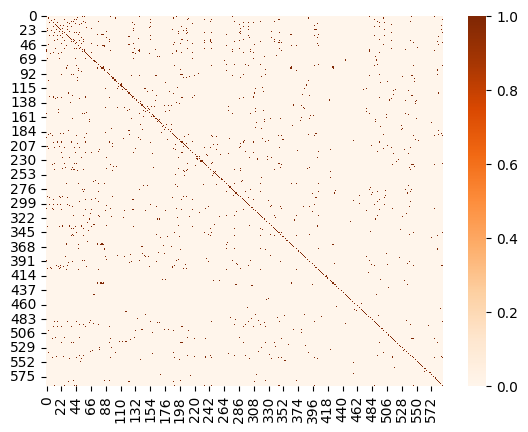

In [ ]:
sigma2=0.3
epsilon=0.4

W = distance_to_weight(distances, gat_version=config['USE_GAT_WEIGHTS'], sigma2=sigma2, epsilon=epsilon)
#
sns.heatmap(W, cmap='Oranges')

Now define the splitting strategy for the dataset.

In [ ]:
def get_splits(dataset: BikeshareDataset, n_slot, splits):
    """
    Given the data, split it into subsets of train, val, and test as given by splits
    dataset: BikeshareDataset object to split
    n_slot: Number of possible sliding windows in a day
    splits: (train, val, test) ratios
    """
    split_train, split_val, _ = splits
    i = n_slot*split_train
    j = n_slot*split_val
    train = dataset[:i]
    val = dataset[i:i+j]
    test = dataset[i+j:]

    return train, val, test

In [ ]:
# total of 31 days of March 2023 in the dataset, use the first 25 for training, 3 for val, 3 for test
train, val, test = get_splits(dataset, config['N_SLOT'], (25, 3, 3))
train_dataloader = DataLoader(train, batch_size=config['BATCH_SIZE'], shuffle=True)
val_dataloader = DataLoader(val, batch_size=config['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(test, batch_size=config['BATCH_SIZE'], shuffle=False)

# Defining Model Architecture and Functions

In [ ]:
# GAT model

import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class ST_GAT(torch.nn.Module):
    """
    Spatio-Temporal Graph Attention Network as presented in https://ieeexplore.ieee.org/document/8903252
    """
    def __init__(self, in_channels, out_channels, n_nodes, heads=8, dropout=0.0):
        """
        Initialize the ST-GAT model
        in_channels: Number of input channels
        out_channels: Number of output channels
        n_nodes: Number of nodes in the graph
        heads: Number of attention heads to use in graph
        dropout: Dropout probability on output of Graph Attention Network
        """
        super(ST_GAT, self).__init__()
        self.n_pred = out_channels
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        # self.n_preds = 3
        lstm1_hidden_size = 32
        lstm2_hidden_size = 128

        # single graph attentional layer with 8 attention heads
        self.gat = GATConv(in_channels=in_channels, out_channels=in_channels,
            heads=heads, dropout=0, concat=False)

        # add two LSTM layers
        self.lstm1 = torch.nn.LSTM(input_size=self.n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
        self.lstm2 = torch.nn.LSTM(input_size=lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                torch.nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                torch.nn.init.xavier_uniform_(param)

        # fully-connected neural network
        self.linear = torch.nn.Linear(lstm2_hidden_size, self.n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, data, device):
        """
        Forward pass of the ST-GAT model
        :param data Data to make a pass on
        :param device Device to operate on
        """
        x, edge_index = data.x, data.edge_index
        # apply dropout
        if device == 'cpu':
            x = torch.FloatTensor(x)
        else:
            x = torch.cuda.FloatTensor(x)

        # gat layer: output of gat: [11400, 12]
        x = self.gat(x, edge_index)
        x = F.dropout(x, self.dropout, training=self.training)

        # RNN: 2 LSTM
        # [batchsize*n_nodes, seq_length] -> [batch_size, n_nodes, seq_length]
        batch_size = data.num_graphs
        n_node = int(data.num_nodes/batch_size)
        x = torch.reshape(x, (batch_size, n_node, data.num_features))
        # for lstm: x should be (seq_length, batch_size, n_nodes)
        # sequence length = 12, batch_size = 50, n_node = 228
        x = torch.movedim(x, 2, 0)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        # Output contains h_t for each timestep, only the last one has all input's accounted for
        x = torch.squeeze(x[-1, :, :])
        x = self.linear(x)

        # Now reshape into final output
        s = x.shape
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))
        x = torch.reshape(x, (s[0]*self.n_nodes, self.n_pred))
        return x

Adding train, eval and test functions:

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

# Make a tensorboard writer
writer = SummaryWriter()

@torch.no_grad()
def eval(model, device, dataloader, type=''):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param type Name of evaluation type, e.g. Train/Val/Test
    """
    model.eval()
    model.to(device)

    mae = 0
    rmse = 0
    mape = 0
    n = 0

    # Evaluate model on all data
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, device)
            truth = batch.y.view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
            truth = un_z_score(truth, dataloader.dataset.mean, dataloader.dataset.std_dev)
            pred = un_z_score(pred, dataloader.dataset.mean, dataloader.dataset.std_dev)
            y_pred[i, :pred.shape[0], :] = pred
            y_truth[i, :pred.shape[0], :] = truth

            rmse += RMSE(truth, pred)
            mae += MAE(truth, pred)
            mape += MAPE(truth, pred)
            n += 1
    rmse, mae, mape = rmse / n, mae / n, mape / n

    print(f'{type}, MAE: {mae}, RMSE: {rmse}, MAPE: {mape}')
    #get the average score for each metric in each batch
    return rmse, mae, mape, y_pred, y_truth

def train(model, device, dataloader, optimizer, loss_fn, epoch):
    """
    Evaluation function to evaluate model on data
    :param model Model to evaluate
    :param device Device to evaluate on
    :param dataloader Data loader
    :param optimizer Optimizer to use
    :param loss_fn Loss function
    :param epoch Current epoch
    """
    model.train()
    for _, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}")):
        batch = batch.to(device)
        optimizer.zero_grad()
        y_pred = torch.squeeze(model(batch, device))
        loss = loss_fn()(y_pred.float(), torch.squeeze(batch.y).float())
        writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()

    return loss

def model_train(train_dataloader, val_dataloader, config, device):
    """
    Train the ST-GAT model. Evaluate on validation dataset as you go.
    :param train_dataloader Data loader of training dataset
    :param val_dataloader Dataloader of val dataset
    :param config configuration to use
    :param device Device to evaluate on
    """

    # Make the model. Each datapoint in the graph is N x F (N = # nodes, F = time window)
    model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'], dropout=config['DROPOUT'])
    optimizer = optim.Adam(model.parameters(), lr=config['INITIAL_LR'], weight_decay=config['WEIGHT_DECAY'])
    loss_fn = torch.nn.MSELoss

    model.to(device)
    train_maes, train_rmses, train_mapes, val_maes, val_rmses, val_mapes = [],[],[],[],[],[]
    epochs = []
    # For every epoch, train the model on training dataset. Evaluate model on validation dataset
    for epoch in range(config['EPOCHS']):
        loss = train(model, device, train_dataloader, optimizer, loss_fn, epoch)
        print(f"Loss: {loss:.3f}")
        if epoch % 5 == 0:
            train_mae, train_rmse, train_mape, _, _ = eval(model, device, train_dataloader, 'Train')
            val_mae, val_rmse, val_mape, _, _ = eval(model, device, val_dataloader, 'Valid')
            writer.add_scalar(f"MAE/train", train_mae, epoch)
            writer.add_scalar(f"RMSE/train", train_rmse, epoch)
            writer.add_scalar(f"MAPE/train", train_mape, epoch)
            writer.add_scalar(f"MAE/val", val_mae, epoch)
            writer.add_scalar(f"RMSE/val", val_rmse, epoch)
            writer.add_scalar(f"MAPE/val", val_mape, epoch)
            train_maes.append(train_mae.item())
            train_rmses.append(train_rmse.item())
            train_mapes.append(train_mape.item())
            val_maes.append(val_mae.item())
            val_rmses.append(val_rmse.item())
            val_mapes.append(val_mape.item())
            epochs.append(epoch)

    writer.flush()
    # Save the model
    timestr = time.strftime("%m-%d-%H%M%S")
    torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
            }, os.path.join(config["CHECKPOINT_DIR"], f"model_{timestr}.pt"))

    return model, train_maes, train_rmses, train_mapes, val_maes, val_rmses, val_mapes, epochs

def model_test(model, test_dataloader, device, config):
    """
    Test the ST-GAT model
    :param test_dataloader Data loader of test dataset
    :param device Device to evaluate on
    """
    rmse, mae, mape, y_pred, y_truth = eval(model, device, test_dataloader, 'Test')
    return rmse, mae, mape, y_pred, y_truth

def plot_prediction(y_truth,y_pred,node, config):
    # Calculate the truth
    s = y_truth.shape
    y_truth = y_truth.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_truth = y_truth[:, :, node, 0]
    # Flatten to get the predictions for entire test dataset
    y_truth = torch.flatten(y_truth)
    day0_truth = y_truth[:config['N_SLOT']]


    # Calculate the predicted
    s = y_pred.shape
    y_pred = y_pred.reshape(s[0], config['BATCH_SIZE'], config['N_NODE'], s[-1])
    # just get the first prediction out for the nth node
    y_pred = y_pred[:, :, node, 0]
    # Flatten to get the predictions for entire test dataset
    y_pred = torch.flatten(y_pred)
    # Just grab the first day
    day0_pred = y_pred[:config['N_SLOT']]
    print(len(day0_pred))
    t = [t for t in range(0, config['N_SLOT'])]
    plt.plot(t, day0_pred, label='ST-GAT')
    plt.plot(t, day0_truth, label='truth')
    plt.xlabel('Time')
    plt.ylabel('Availability prediction')
    plt.title('Predictions of bike availability over time')
    plt.legend()
    # plt.savefig('predicted_times.png')
    plt.show()



def load_from_checkpoint(checkpoint_path, config):
    """
    Load a model from the checkpoint
    :param checkpoint_path Path to checkpoint
    :param config Configuration to load model with
    """
    model = ST_GAT(in_channels=config['N_HIST'], out_channels=config['N_PRED'], n_nodes=config['N_NODE'])
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])

    return model


# Running the GNN

In [ ]:
 # Get gpu if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cpu


In [ ]:
# config['N_NODE'] = dataset.n_node
model = model_train(train_dataloader, val_dataloader, config, device)

Epoch 0: 100%|██████████| 29/29 [00:00<00:00, 107.55it/s]


Loss: 0.268
Train, MAE: 0.768794596195221, RMSE: 1.6174325942993164, MAPE: 7.238144397735596
Valid, MAE: 0.8987541794776917, RMSE: 1.7842183113098145, MAPE: 8.92630672454834


Epoch 1: 100%|██████████| 29/29 [00:00<00:00, 127.62it/s]


Loss: 0.102


Epoch 2: 100%|██████████| 29/29 [00:00<00:00, 139.95it/s]


Loss: 0.106


Epoch 3: 100%|██████████| 29/29 [00:00<00:00, 135.95it/s]


Loss: 0.128


Epoch 4: 100%|██████████| 29/29 [00:00<00:00, 141.48it/s]


Loss: 0.017


Epoch 5: 100%|██████████| 29/29 [00:00<00:00, 133.98it/s]


Loss: 0.060
Train, MAE: 0.5647481083869934, RMSE: 1.0627069473266602, MAPE: 6.118630886077881
Valid, MAE: 0.6933910250663757, RMSE: 1.260927677154541, MAPE: 7.714357376098633


Epoch 6: 100%|██████████| 29/29 [00:00<00:00, 142.46it/s]


Loss: 0.057


Epoch 7: 100%|██████████| 29/29 [00:00<00:00, 137.79it/s]


Loss: 0.076


Epoch 8: 100%|██████████| 29/29 [00:00<00:00, 142.72it/s]


Loss: 0.029


Epoch 9: 100%|██████████| 29/29 [00:00<00:00, 137.05it/s]


Loss: 0.112


Epoch 10: 100%|██████████| 29/29 [00:00<00:00, 137.97it/s]


Loss: 0.148
Train, MAE: 0.5661250352859497, RMSE: 1.0689499378204346, MAPE: 6.126148223876953
Valid, MAE: 0.7335986495018005, RMSE: 1.3155162334442139, MAPE: 8.194208145141602


Epoch 11: 100%|██████████| 29/29 [00:00<00:00, 135.62it/s]


Loss: 0.082


Epoch 12: 100%|██████████| 29/29 [00:00<00:00, 139.35it/s]


Loss: 0.127


Epoch 13: 100%|██████████| 29/29 [00:00<00:00, 122.43it/s]


Loss: 0.070


Epoch 14: 100%|██████████| 29/29 [00:00<00:00, 140.91it/s]


Loss: 0.048


Epoch 15: 100%|██████████| 29/29 [00:00<00:00, 139.24it/s]


Loss: 0.105
Train, MAE: 0.558605968952179, RMSE: 1.0657933950424194, MAPE: 6.032541751861572
Valid, MAE: 0.7215625047683716, RMSE: 1.315194845199585, MAPE: 8.023280143737793


Epoch 16: 100%|██████████| 29/29 [00:00<00:00, 129.53it/s]


Loss: 0.101


Epoch 17: 100%|██████████| 29/29 [00:00<00:00, 138.22it/s]


Loss: 0.081


Epoch 18: 100%|██████████| 29/29 [00:00<00:00, 140.71it/s]


Loss: 0.086


Epoch 19: 100%|██████████| 29/29 [00:00<00:00, 145.59it/s]


Loss: 0.069


Epoch 20: 100%|██████████| 29/29 [00:00<00:00, 147.17it/s]


Loss: 0.043
Train, MAE: 0.5633602738380432, RMSE: 1.0603169202804565, MAPE: 6.082680702209473
Valid, MAE: 0.7177066802978516, RMSE: 1.3007713556289673, MAPE: 8.011627197265625


Epoch 21: 100%|██████████| 29/29 [00:00<00:00, 128.13it/s]


Loss: 0.073


Epoch 22: 100%|██████████| 29/29 [00:00<00:00, 140.72it/s]


Loss: 0.066


Epoch 23: 100%|██████████| 29/29 [00:00<00:00, 113.89it/s]


Loss: 0.057


Epoch 24: 100%|██████████| 29/29 [00:00<00:00, 98.85it/s]


Loss: 0.061


Epoch 25: 100%|██████████| 29/29 [00:00<00:00, 97.40it/s]


Loss: 0.031
Train, MAE: 0.5788854360580444, RMSE: 1.0757477283477783, MAPE: 6.25233793258667
Valid, MAE: 0.7306764125823975, RMSE: 1.301584243774414, MAPE: 8.104939460754395


Epoch 26: 100%|██████████| 29/29 [00:00<00:00, 107.56it/s]


Loss: 0.118


Epoch 27: 100%|██████████| 29/29 [00:00<00:00, 100.92it/s]


Loss: 0.110


Epoch 28: 100%|██████████| 29/29 [00:00<00:00, 104.54it/s]


Loss: 0.130


Epoch 29: 100%|██████████| 29/29 [00:00<00:00, 99.31it/s] 


Loss: 0.205


Epoch 30: 100%|██████████| 29/29 [00:00<00:00, 104.84it/s]


Loss: 0.074
Train, MAE: 0.5629254579544067, RMSE: 1.0576215982437134, MAPE: 6.086043834686279
Valid, MAE: 0.7156636714935303, RMSE: 1.2971396446228027, MAPE: 7.966935157775879


Epoch 31: 100%|██████████| 29/29 [00:00<00:00, 103.83it/s]


Loss: 0.104


Epoch 32: 100%|██████████| 29/29 [00:00<00:00, 109.11it/s]


Loss: 0.165


Epoch 33: 100%|██████████| 29/29 [00:00<00:00, 108.32it/s]


Loss: 0.125


Epoch 34: 100%|██████████| 29/29 [00:00<00:00, 105.37it/s]


Loss: 0.091


Epoch 35: 100%|██████████| 29/29 [00:00<00:00, 111.86it/s]


Loss: 0.033
Train, MAE: 0.5498965978622437, RMSE: 1.0253113508224487, MAPE: 5.976008892059326
Valid, MAE: 0.7149856686592102, RMSE: 1.3164502382278442, MAPE: 8.051460266113281


Epoch 36: 100%|██████████| 29/29 [00:00<00:00, 91.77it/s]


Loss: 0.069


Epoch 37: 100%|██████████| 29/29 [00:00<00:00, 88.92it/s]


Loss: 0.040


Epoch 38: 100%|██████████| 29/29 [00:00<00:00, 138.70it/s]


Loss: 0.123


Epoch 39: 100%|██████████| 29/29 [00:00<00:00, 144.16it/s]


Loss: 0.030


Epoch 40: 100%|██████████| 29/29 [00:00<00:00, 136.61it/s]


Loss: 0.150
Train, MAE: 0.5407482981681824, RMSE: 0.9973384141921997, MAPE: 5.879556655883789
Valid, MAE: 0.7197778224945068, RMSE: 1.3087730407714844, MAPE: 8.104707717895508


Epoch 41: 100%|██████████| 29/29 [00:00<00:00, 133.29it/s]


Loss: 0.079


Epoch 42: 100%|██████████| 29/29 [00:00<00:00, 134.22it/s]


Loss: 0.072


Epoch 43: 100%|██████████| 29/29 [00:00<00:00, 137.47it/s]


Loss: 0.047


Epoch 44: 100%|██████████| 29/29 [00:00<00:00, 136.91it/s]


Loss: 0.149


Epoch 45: 100%|██████████| 29/29 [00:00<00:00, 134.36it/s]


Loss: 0.177
Train, MAE: 0.5490754246711731, RMSE: 0.9789631366729736, MAPE: 5.8941330909729
Valid, MAE: 0.7300798296928406, RMSE: 1.298496961593628, MAPE: 8.144224166870117


Epoch 46: 100%|██████████| 29/29 [00:00<00:00, 141.34it/s]


Loss: 0.095


Epoch 47: 100%|██████████| 29/29 [00:00<00:00, 139.57it/s]


Loss: 0.059


Epoch 48: 100%|██████████| 29/29 [00:00<00:00, 132.26it/s]


Loss: 0.043


Epoch 49: 100%|██████████| 29/29 [00:00<00:00, 129.70it/s]


Loss: 0.070


Epoch 50: 100%|██████████| 29/29 [00:00<00:00, 128.65it/s]


Loss: 0.063
Train, MAE: 0.5288811326026917, RMSE: 0.9622980952262878, MAPE: 5.741525173187256
Valid, MAE: 0.7163504362106323, RMSE: 1.2720260620117188, MAPE: 8.062661170959473


Epoch 51: 100%|██████████| 29/29 [00:00<00:00, 130.59it/s]


Loss: 0.041


Epoch 52: 100%|██████████| 29/29 [00:00<00:00, 133.54it/s]


Loss: 0.115


Epoch 53: 100%|██████████| 29/29 [00:00<00:00, 129.73it/s]


Loss: 0.094


Epoch 54: 100%|██████████| 29/29 [00:00<00:00, 134.00it/s]


Loss: 0.072


Epoch 55: 100%|██████████| 29/29 [00:00<00:00, 134.83it/s]


Loss: 0.097
Train, MAE: 0.5267515778541565, RMSE: 0.9499730467796326, MAPE: 5.687488079071045
Valid, MAE: 0.6942671537399292, RMSE: 1.2213342189788818, MAPE: 7.7089715003967285


Epoch 56: 100%|██████████| 29/29 [00:00<00:00, 131.58it/s]


Loss: 0.062


Epoch 57: 100%|██████████| 29/29 [00:00<00:00, 133.85it/s]


Loss: 0.115


Epoch 58: 100%|██████████| 29/29 [00:00<00:00, 137.27it/s]


Loss: 0.084


Epoch 59: 100%|██████████| 29/29 [00:00<00:00, 135.29it/s]


Loss: 0.073


Epoch 60: 100%|██████████| 29/29 [00:00<00:00, 137.01it/s]


Loss: 0.065
Train, MAE: 0.5276548266410828, RMSE: 0.9468014240264893, MAPE: 5.726959705352783
Valid, MAE: 0.7070848941802979, RMSE: 1.2462313175201416, MAPE: 7.918129920959473


Epoch 61: 100%|██████████| 29/29 [00:00<00:00, 132.26it/s]


Loss: 0.076


Epoch 62: 100%|██████████| 29/29 [00:00<00:00, 141.07it/s]


Loss: 0.022


Epoch 63: 100%|██████████| 29/29 [00:00<00:00, 131.10it/s]


Loss: 0.082


Epoch 64: 100%|██████████| 29/29 [00:00<00:00, 140.62it/s]


Loss: 0.101


Epoch 65: 100%|██████████| 29/29 [00:00<00:00, 142.30it/s]


Loss: 0.131
Train, MAE: 0.5185104012489319, RMSE: 0.9404005408287048, MAPE: 5.616848945617676
Valid, MAE: 0.6494726538658142, RMSE: 1.1572061777114868, MAPE: 7.25322961807251


Epoch 66: 100%|██████████| 29/29 [00:00<00:00, 139.63it/s]


Loss: 0.093


Epoch 67: 100%|██████████| 29/29 [00:00<00:00, 132.12it/s]


Loss: 0.087


Epoch 68: 100%|██████████| 29/29 [00:00<00:00, 131.07it/s]


Loss: 0.128


Epoch 69: 100%|██████████| 29/29 [00:00<00:00, 139.26it/s]


Loss: 0.146


Epoch 70: 100%|██████████| 29/29 [00:00<00:00, 134.98it/s]


Loss: 0.125
Train, MAE: 0.5146351456642151, RMSE: 0.9289258122444153, MAPE: 5.564259052276611
Valid, MAE: 0.7142710089683533, RMSE: 1.25797700881958, MAPE: 7.959362030029297


Epoch 71: 100%|██████████| 29/29 [00:00<00:00, 132.02it/s]


Loss: 0.131


Epoch 72: 100%|██████████| 29/29 [00:00<00:00, 140.68it/s]


Loss: 0.070


Epoch 73: 100%|██████████| 29/29 [00:00<00:00, 139.80it/s]


Loss: 0.097


Epoch 74: 100%|██████████| 29/29 [00:00<00:00, 128.75it/s]


Loss: 0.055


Epoch 75: 100%|██████████| 29/29 [00:00<00:00, 130.81it/s]


Loss: 0.054
Train, MAE: 0.5167652368545532, RMSE: 0.9353830218315125, MAPE: 5.58826208114624
Valid, MAE: 0.7090522050857544, RMSE: 1.2492823600769043, MAPE: 7.920000076293945


Epoch 76: 100%|██████████| 29/29 [00:00<00:00, 131.56it/s]


Loss: 0.063


Epoch 77: 100%|██████████| 29/29 [00:00<00:00, 106.31it/s]


Loss: 0.117


Epoch 78: 100%|██████████| 29/29 [00:00<00:00, 96.36it/s]


Loss: 0.107


Epoch 79: 100%|██████████| 29/29 [00:00<00:00, 101.47it/s]


Loss: 0.038


Epoch 80: 100%|██████████| 29/29 [00:00<00:00, 108.73it/s]


Loss: 0.060
Train, MAE: 0.5140711665153503, RMSE: 0.9318928122520447, MAPE: 5.575588226318359
Valid, MAE: 0.6771255731582642, RMSE: 1.2130186557769775, MAPE: 7.547565937042236


Epoch 81: 100%|██████████| 29/29 [00:00<00:00, 102.63it/s]


Loss: 0.066


Epoch 82: 100%|██████████| 29/29 [00:00<00:00, 100.94it/s]


Loss: 0.066


Epoch 83: 100%|██████████| 29/29 [00:00<00:00, 99.87it/s]


Loss: 0.042


Epoch 84: 100%|██████████| 29/29 [00:00<00:00, 105.28it/s]


Loss: 0.076


Epoch 85: 100%|██████████| 29/29 [00:00<00:00, 97.92it/s]


Loss: 0.069
Train, MAE: 0.5213601589202881, RMSE: 0.9371301531791687, MAPE: 5.672929286956787
Valid, MAE: 0.69594407081604, RMSE: 1.2297943830490112, MAPE: 7.827911376953125


Epoch 86: 100%|██████████| 29/29 [00:00<00:00, 105.31it/s]


Loss: 0.065


Epoch 87: 100%|██████████| 29/29 [00:00<00:00, 107.24it/s]


Loss: 0.058


Epoch 88: 100%|██████████| 29/29 [00:00<00:00, 100.83it/s]


Loss: 0.075


Epoch 89: 100%|██████████| 29/29 [00:00<00:00, 104.60it/s]


Loss: 0.039


Epoch 90: 100%|██████████| 29/29 [00:00<00:00, 96.66it/s] 


Loss: 0.058
Train, MAE: 0.5016934275627136, RMSE: 0.9101802110671997, MAPE: 5.431674480438232
Valid, MAE: 0.6886371374130249, RMSE: 1.2296487092971802, MAPE: 7.701161861419678


Epoch 91: 100%|██████████| 29/29 [00:00<00:00, 115.46it/s]


Loss: 0.041


Epoch 92: 100%|██████████| 29/29 [00:00<00:00, 138.71it/s]


Loss: 0.074


Epoch 93: 100%|██████████| 29/29 [00:00<00:00, 137.22it/s]


Loss: 0.109


Epoch 94: 100%|██████████| 29/29 [00:00<00:00, 126.47it/s]


Loss: 0.091


Epoch 95: 100%|██████████| 29/29 [00:00<00:00, 131.66it/s]


Loss: 0.065
Train, MAE: 0.513295590877533, RMSE: 0.9235795736312866, MAPE: 5.577243804931641
Valid, MAE: 0.6874351501464844, RMSE: 1.2147095203399658, MAPE: 7.661405563354492


Epoch 96: 100%|██████████| 29/29 [00:00<00:00, 139.90it/s]


Loss: 0.068


Epoch 97: 100%|██████████| 29/29 [00:00<00:00, 128.61it/s]


Loss: 0.064


Epoch 98: 100%|██████████| 29/29 [00:00<00:00, 132.94it/s]


Loss: 0.085


Epoch 99: 100%|██████████| 29/29 [00:00<00:00, 136.95it/s]


Loss: 0.075


Epoch 100: 100%|██████████| 29/29 [00:00<00:00, 133.31it/s]


Loss: 0.041
Train, MAE: 0.5258136987686157, RMSE: 0.9306902885437012, MAPE: 5.734215259552002
Valid, MAE: 0.7028588652610779, RMSE: 1.2315247058868408, MAPE: 7.912842750549316


Epoch 101: 100%|██████████| 29/29 [00:00<00:00, 123.38it/s]


Loss: 0.037


Epoch 102: 100%|██████████| 29/29 [00:00<00:00, 134.24it/s]


Loss: 0.049


Epoch 103: 100%|██████████| 29/29 [00:00<00:00, 140.38it/s]


Loss: 0.079


Epoch 104: 100%|██████████| 29/29 [00:00<00:00, 143.60it/s]


Loss: 0.088


Epoch 105: 100%|██████████| 29/29 [00:00<00:00, 140.44it/s]


Loss: 0.078
Train, MAE: 0.5116144418716431, RMSE: 0.915982723236084, MAPE: 5.568296909332275
Valid, MAE: 0.6765162944793701, RMSE: 1.1943812370300293, MAPE: 7.564335346221924


Epoch 106: 100%|██████████| 29/29 [00:00<00:00, 136.78it/s]


Loss: 0.052


Epoch 107: 100%|██████████| 29/29 [00:00<00:00, 136.09it/s]


Loss: 0.034


Epoch 108: 100%|██████████| 29/29 [00:00<00:00, 133.46it/s]


Loss: 0.023


Epoch 109: 100%|██████████| 29/29 [00:00<00:00, 136.39it/s]


Loss: 0.086


Epoch 110: 100%|██████████| 29/29 [00:00<00:00, 127.36it/s]


Loss: 0.066
Train, MAE: 0.5037912726402283, RMSE: 0.8998790383338928, MAPE: 5.4575300216674805
Valid, MAE: 0.6952099204063416, RMSE: 1.2183139324188232, MAPE: 7.804319381713867


Epoch 111: 100%|██████████| 29/29 [00:00<00:00, 128.49it/s]


Loss: 0.053


Epoch 112: 100%|██████████| 29/29 [00:00<00:00, 138.83it/s]


Loss: 0.063


Epoch 113: 100%|██████████| 29/29 [00:00<00:00, 130.07it/s]


Loss: 0.077


Epoch 114: 100%|██████████| 29/29 [00:00<00:00, 118.77it/s]


Loss: 0.084


Epoch 115: 100%|██████████| 29/29 [00:00<00:00, 130.91it/s]


Loss: 0.094
Train, MAE: 0.49590444564819336, RMSE: 0.8905898928642273, MAPE: 5.379893779754639
Valid, MAE: 0.6929745674133301, RMSE: 1.2087081670761108, MAPE: 7.734233856201172


Epoch 116: 100%|██████████| 29/29 [00:00<00:00, 139.20it/s]


Loss: 0.046


Epoch 117: 100%|██████████| 29/29 [00:00<00:00, 124.04it/s]


Loss: 0.069


Epoch 118: 100%|██████████| 29/29 [00:00<00:00, 126.77it/s]


Loss: 0.049


Epoch 119: 100%|██████████| 29/29 [00:00<00:00, 125.83it/s]


Loss: 0.045


Epoch 120: 100%|██████████| 29/29 [00:00<00:00, 134.53it/s]


Loss: 0.041
Train, MAE: 0.49604514241218567, RMSE: 0.894456148147583, MAPE: 5.385011672973633
Valid, MAE: 0.7126216292381287, RMSE: 1.2440884113311768, MAPE: 7.962679862976074


Epoch 121: 100%|██████████| 29/29 [00:00<00:00, 133.67it/s]


Loss: 0.096


Epoch 122: 100%|██████████| 29/29 [00:00<00:00, 139.79it/s]


Loss: 0.081


Epoch 123: 100%|██████████| 29/29 [00:00<00:00, 128.29it/s]


Loss: 0.053


Epoch 124: 100%|██████████| 29/29 [00:00<00:00, 140.97it/s]


Loss: 0.050


Epoch 125: 100%|██████████| 29/29 [00:00<00:00, 133.04it/s]


Loss: 0.044
Train, MAE: 0.5008611083030701, RMSE: 0.8931348323822021, MAPE: 5.416632175445557
Valid, MAE: 0.6726921200752258, RMSE: 1.1835505962371826, MAPE: 7.5140886306762695


Epoch 126: 100%|██████████| 29/29 [00:00<00:00, 135.87it/s]


Loss: 0.100


Epoch 127: 100%|██████████| 29/29 [00:00<00:00, 135.22it/s]


Loss: 0.059


Epoch 128: 100%|██████████| 29/29 [00:00<00:00, 130.58it/s]


Loss: 0.068


Epoch 129: 100%|██████████| 29/29 [00:00<00:00, 125.89it/s]


Loss: 0.042


Epoch 130: 100%|██████████| 29/29 [00:00<00:00, 122.52it/s]


Loss: 0.075
Train, MAE: 0.5023925304412842, RMSE: 0.8942888975143433, MAPE: 5.438869476318359
Valid, MAE: 0.6925511360168457, RMSE: 1.2113347053527832, MAPE: 7.756250858306885


Epoch 131: 100%|██████████| 29/29 [00:00<00:00, 102.55it/s]


Loss: 0.045


Epoch 132: 100%|██████████| 29/29 [00:00<00:00, 100.69it/s]


Loss: 0.114


Epoch 133: 100%|██████████| 29/29 [00:00<00:00, 95.53it/s]


Loss: 0.043


Epoch 134: 100%|██████████| 29/29 [00:00<00:00, 107.01it/s]


Loss: 0.042


Epoch 135: 100%|██████████| 29/29 [00:00<00:00, 101.55it/s]


Loss: 0.102
Train, MAE: 0.49160704016685486, RMSE: 0.882416844367981, MAPE: 5.354973316192627
Valid, MAE: 0.6969401240348816, RMSE: 1.2237563133239746, MAPE: 7.791718482971191


Epoch 136: 100%|██████████| 29/29 [00:00<00:00, 101.32it/s]


Loss: 0.030


Epoch 137: 100%|██████████| 29/29 [00:00<00:00, 105.93it/s]


Loss: 0.071


Epoch 138: 100%|██████████| 29/29 [00:00<00:00, 105.76it/s]


Loss: 0.072


Epoch 139: 100%|██████████| 29/29 [00:00<00:00, 103.39it/s]


Loss: 0.028


Epoch 140: 100%|██████████| 29/29 [00:00<00:00, 107.55it/s]


Loss: 0.043
Train, MAE: 0.4901024103164673, RMSE: 0.879384458065033, MAPE: 5.309261798858643
Valid, MAE: 0.6457890868186951, RMSE: 1.1444028615951538, MAPE: 7.198273658752441


Epoch 141: 100%|██████████| 29/29 [00:00<00:00, 101.14it/s]


Loss: 0.087


Epoch 142: 100%|██████████| 29/29 [00:00<00:00, 101.81it/s]


Loss: 0.052


Epoch 143: 100%|██████████| 29/29 [00:00<00:00, 101.71it/s]


Loss: 0.094


Epoch 144: 100%|██████████| 29/29 [00:00<00:00, 95.67it/s]


Loss: 0.054


Epoch 145: 100%|██████████| 29/29 [00:00<00:00, 131.76it/s]


Loss: 0.097
Train, MAE: 0.4953520894050598, RMSE: 0.8866899013519287, MAPE: 5.378117084503174
Valid, MAE: 0.6646048426628113, RMSE: 1.172947645187378, MAPE: 7.405697822570801


Epoch 146: 100%|██████████| 29/29 [00:00<00:00, 140.00it/s]


Loss: 0.062


Epoch 147: 100%|██████████| 29/29 [00:00<00:00, 140.74it/s]


Loss: 0.043


Epoch 148: 100%|██████████| 29/29 [00:00<00:00, 133.76it/s]


Loss: 0.099


Epoch 149: 100%|██████████| 29/29 [00:00<00:00, 141.05it/s]


Loss: 0.039


Epoch 150: 100%|██████████| 29/29 [00:00<00:00, 129.74it/s]


Loss: 0.101
Train, MAE: 0.49600985646247864, RMSE: 0.8842171430587769, MAPE: 5.389984130859375
Valid, MAE: 0.7051590085029602, RMSE: 1.2358720302581787, MAPE: 7.845549583435059


Epoch 151: 100%|██████████| 29/29 [00:00<00:00, 132.84it/s]


Loss: 0.025


Epoch 152: 100%|██████████| 29/29 [00:00<00:00, 132.82it/s]


Loss: 0.095


Epoch 153: 100%|██████████| 29/29 [00:00<00:00, 142.79it/s]


Loss: 0.022


Epoch 154: 100%|██████████| 29/29 [00:00<00:00, 132.42it/s]


Loss: 0.117


Epoch 155: 100%|██████████| 29/29 [00:00<00:00, 138.84it/s]


Loss: 0.072
Train, MAE: 0.5015730857849121, RMSE: 0.8919612765312195, MAPE: 5.4561004638671875
Valid, MAE: 0.6844392418861389, RMSE: 1.195979356765747, MAPE: 7.635412693023682


Epoch 156: 100%|██████████| 29/29 [00:00<00:00, 133.73it/s]


Loss: 0.056


Epoch 157: 100%|██████████| 29/29 [00:00<00:00, 142.48it/s]


Loss: 0.029


Epoch 158: 100%|██████████| 29/29 [00:00<00:00, 124.83it/s]


Loss: 0.085


Epoch 159: 100%|██████████| 29/29 [00:00<00:00, 137.16it/s]


Loss: 0.085


Epoch 160: 100%|██████████| 29/29 [00:00<00:00, 132.82it/s]


Loss: 0.040
Train, MAE: 0.49411359429359436, RMSE: 0.8867530822753906, MAPE: 5.3761210441589355
Valid, MAE: 0.6817433834075928, RMSE: 1.1981691122055054, MAPE: 7.606544494628906


Epoch 161: 100%|██████████| 29/29 [00:00<00:00, 140.35it/s]


Loss: 0.092


Epoch 162: 100%|██████████| 29/29 [00:00<00:00, 129.53it/s]


Loss: 0.058


Epoch 163: 100%|██████████| 29/29 [00:00<00:00, 139.57it/s]


Loss: 0.057


Epoch 164: 100%|██████████| 29/29 [00:00<00:00, 136.66it/s]


Loss: 0.072


Epoch 165: 100%|██████████| 29/29 [00:00<00:00, 133.88it/s]


Loss: 0.040
Train, MAE: 0.4934287965297699, RMSE: 0.8795610666275024, MAPE: 5.35597562789917
Valid, MAE: 0.6675242781639099, RMSE: 1.1765880584716797, MAPE: 7.460361957550049


Epoch 166: 100%|██████████| 29/29 [00:00<00:00, 128.12it/s]


Loss: 0.046


Epoch 167: 100%|██████████| 29/29 [00:00<00:00, 134.89it/s]


Loss: 0.078


Epoch 168: 100%|██████████| 29/29 [00:00<00:00, 128.32it/s]


Loss: 0.035


Epoch 169: 100%|██████████| 29/29 [00:00<00:00, 137.21it/s]


Loss: 0.085


Epoch 170: 100%|██████████| 29/29 [00:00<00:00, 138.79it/s]


Loss: 0.053
Train, MAE: 0.5063964128494263, RMSE: 0.8994365334510803, MAPE: 5.503420352935791
Valid, MAE: 0.6917628049850464, RMSE: 1.2137738466262817, MAPE: 7.762673377990723


Epoch 171: 100%|██████████| 29/29 [00:00<00:00, 131.08it/s]


Loss: 0.035


Epoch 172: 100%|██████████| 29/29 [00:00<00:00, 134.76it/s]


Loss: 0.051


Epoch 173: 100%|██████████| 29/29 [00:00<00:00, 138.67it/s]


Loss: 0.058


Epoch 174: 100%|██████████| 29/29 [00:00<00:00, 127.85it/s]


Loss: 0.026


Epoch 175: 100%|██████████| 29/29 [00:00<00:00, 134.23it/s]


Loss: 0.031
Train, MAE: 0.5005872249603271, RMSE: 0.8884178400039673, MAPE: 5.442013263702393
Valid, MAE: 0.6692872643470764, RMSE: 1.1782546043395996, MAPE: 7.47656774520874


Epoch 176: 100%|██████████| 29/29 [00:00<00:00, 141.56it/s]


Loss: 0.070


Epoch 177: 100%|██████████| 29/29 [00:00<00:00, 138.91it/s]


Loss: 0.190


Epoch 178: 100%|██████████| 29/29 [00:00<00:00, 130.77it/s]


Loss: 0.059


Epoch 179: 100%|██████████| 29/29 [00:00<00:00, 131.64it/s]


Loss: 0.040


Epoch 180: 100%|██████████| 29/29 [00:00<00:00, 137.75it/s]


Loss: 0.073
Train, MAE: 0.5009376406669617, RMSE: 0.8900125622749329, MAPE: 5.439931869506836
Valid, MAE: 0.6805540323257446, RMSE: 1.208643913269043, MAPE: 7.607363224029541


Epoch 181: 100%|██████████| 29/29 [00:00<00:00, 137.10it/s]


Loss: 0.080


Epoch 182: 100%|██████████| 29/29 [00:00<00:00, 132.20it/s]


Loss: 0.035


Epoch 183: 100%|██████████| 29/29 [00:00<00:00, 136.01it/s]


Loss: 0.058


Epoch 184: 100%|██████████| 29/29 [00:00<00:00, 99.43it/s]


Loss: 0.056


Epoch 185: 100%|██████████| 29/29 [00:00<00:00, 104.55it/s]


Loss: 0.045
Train, MAE: 0.4954356253147125, RMSE: 0.8778957724571228, MAPE: 5.372956275939941
Valid, MAE: 0.6868450045585632, RMSE: 1.2011592388153076, MAPE: 7.632073879241943


Epoch 186: 100%|██████████| 29/29 [00:00<00:00, 107.43it/s]


Loss: 0.084


Epoch 187: 100%|██████████| 29/29 [00:00<00:00, 104.13it/s]


Loss: 0.030


Epoch 188: 100%|██████████| 29/29 [00:00<00:00, 99.90it/s] 


Loss: 0.066


Epoch 189: 100%|██████████| 29/29 [00:00<00:00, 104.85it/s]


Loss: 0.079


Epoch 190: 100%|██████████| 29/29 [00:00<00:00, 97.43it/s]


Loss: 0.069
Train, MAE: 0.49235859513282776, RMSE: 0.8773689866065979, MAPE: 5.330080032348633
Valid, MAE: 0.6718819737434387, RMSE: 1.182887077331543, MAPE: 7.508792400360107


Epoch 191: 100%|██████████| 29/29 [00:00<00:00, 108.87it/s]


Loss: 0.040


Epoch 192: 100%|██████████| 29/29 [00:00<00:00, 103.99it/s]


Loss: 0.025


Epoch 193: 100%|██████████| 29/29 [00:00<00:00, 103.37it/s]


Loss: 0.096


Epoch 194: 100%|██████████| 29/29 [00:00<00:00, 107.24it/s]


Loss: 0.008


Epoch 195: 100%|██████████| 29/29 [00:00<00:00, 96.45it/s]


Loss: 0.054
Train, MAE: 0.48869797587394714, RMSE: 0.8756985068321228, MAPE: 5.300806045532227
Valid, MAE: 0.6746361255645752, RMSE: 1.1831296682357788, MAPE: 7.519991397857666


Epoch 196: 100%|██████████| 29/29 [00:00<00:00, 101.01it/s]


Loss: 0.054


Epoch 197: 100%|██████████| 29/29 [00:00<00:00, 101.87it/s]


Loss: 0.061


Epoch 198: 100%|██████████| 29/29 [00:00<00:00, 98.81it/s]


Loss: 0.082


Epoch 199: 100%|██████████| 29/29 [00:00<00:00, 128.67it/s]


Loss: 0.078


Epoch 200: 100%|██████████| 29/29 [00:00<00:00, 142.57it/s]


Loss: 0.041
Train, MAE: 0.4902532696723938, RMSE: 0.8764376640319824, MAPE: 5.3208842277526855
Valid, MAE: 0.6744402647018433, RMSE: 1.2042423486709595, MAPE: 7.517662048339844


Epoch 201: 100%|██████████| 29/29 [00:00<00:00, 134.40it/s]


Loss: 0.092


Epoch 202: 100%|██████████| 29/29 [00:00<00:00, 126.78it/s]


Loss: 0.013


Epoch 203: 100%|██████████| 29/29 [00:00<00:00, 142.69it/s]


Loss: 0.086


Epoch 204: 100%|██████████| 29/29 [00:00<00:00, 140.56it/s]


Loss: 0.118


Epoch 205: 100%|██████████| 29/29 [00:00<00:00, 136.46it/s]


Loss: 0.068
Train, MAE: 0.4937785863876343, RMSE: 0.8756874799728394, MAPE: 5.364677906036377
Valid, MAE: 0.695400595664978, RMSE: 1.2075612545013428, MAPE: 7.774880409240723


Epoch 206: 100%|██████████| 29/29 [00:00<00:00, 127.20it/s]


Loss: 0.048


Epoch 207: 100%|██████████| 29/29 [00:00<00:00, 133.34it/s]


Loss: 0.027


Epoch 208: 100%|██████████| 29/29 [00:00<00:00, 132.80it/s]


Loss: 0.130


Epoch 209: 100%|██████████| 29/29 [00:00<00:00, 119.17it/s]


Loss: 0.092


Epoch 210: 100%|██████████| 29/29 [00:00<00:00, 129.17it/s]


Loss: 0.092
Train, MAE: 0.4810175597667694, RMSE: 0.8593506813049316, MAPE: 5.222280025482178
Valid, MAE: 0.6736513376235962, RMSE: 1.186185598373413, MAPE: 7.5257568359375


Epoch 211: 100%|██████████| 29/29 [00:00<00:00, 132.27it/s]


Loss: 0.075


Epoch 212: 100%|██████████| 29/29 [00:00<00:00, 136.05it/s]


Loss: 0.048


Epoch 213: 100%|██████████| 29/29 [00:00<00:00, 132.21it/s]


Loss: 0.060


Epoch 214: 100%|██████████| 29/29 [00:00<00:00, 129.35it/s]


Loss: 0.141


Epoch 215: 100%|██████████| 29/29 [00:00<00:00, 131.09it/s]


Loss: 0.050
Train, MAE: 0.4863145649433136, RMSE: 0.8694475293159485, MAPE: 5.290977954864502
Valid, MAE: 0.6816887855529785, RMSE: 1.1951706409454346, MAPE: 7.639988899230957


Epoch 216: 100%|██████████| 29/29 [00:00<00:00, 132.66it/s]


Loss: 0.041


Epoch 217: 100%|██████████| 29/29 [00:00<00:00, 132.50it/s]


Loss: 0.044


Epoch 218: 100%|██████████| 29/29 [00:00<00:00, 130.21it/s]


Loss: 0.055


Epoch 219: 100%|██████████| 29/29 [00:00<00:00, 132.14it/s]


Loss: 0.060


Epoch 220: 100%|██████████| 29/29 [00:00<00:00, 133.20it/s]


Loss: 0.081
Train, MAE: 0.4951333701610565, RMSE: 0.8760004043579102, MAPE: 5.384826183319092
Valid, MAE: 0.7064031362533569, RMSE: 1.2268294095993042, MAPE: 7.960352897644043


Epoch 221: 100%|██████████| 29/29 [00:00<00:00, 132.73it/s]


Loss: 0.033


Epoch 222: 100%|██████████| 29/29 [00:00<00:00, 124.34it/s]


Loss: 0.068


Epoch 223: 100%|██████████| 29/29 [00:00<00:00, 133.07it/s]


Loss: 0.035


Epoch 224: 100%|██████████| 29/29 [00:00<00:00, 133.35it/s]


Loss: 0.016


Epoch 225: 100%|██████████| 29/29 [00:00<00:00, 126.36it/s]


Loss: 0.067
Train, MAE: 0.4803088307380676, RMSE: 0.8574923872947693, MAPE: 5.215073108673096
Valid, MAE: 0.6996233463287354, RMSE: 1.2222188711166382, MAPE: 7.86934757232666


Epoch 226: 100%|██████████| 29/29 [00:00<00:00, 131.24it/s]


Loss: 0.065


Epoch 227: 100%|██████████| 29/29 [00:00<00:00, 130.37it/s]


Loss: 0.063


Epoch 228: 100%|██████████| 29/29 [00:00<00:00, 133.35it/s]


Loss: 0.088


Epoch 229: 100%|██████████| 29/29 [00:00<00:00, 121.32it/s]


Loss: 0.059


Epoch 230: 100%|██████████| 29/29 [00:00<00:00, 122.91it/s]


Loss: 0.087
Train, MAE: 0.4876595139503479, RMSE: 0.8658484220504761, MAPE: 5.3023786544799805
Valid, MAE: 0.6633820533752441, RMSE: 1.1600162982940674, MAPE: 7.387269973754883


Epoch 231: 100%|██████████| 29/29 [00:00<00:00, 132.39it/s]


Loss: 0.019


Epoch 232: 100%|██████████| 29/29 [00:00<00:00, 125.65it/s]


Loss: 0.033


Epoch 233: 100%|██████████| 29/29 [00:00<00:00, 132.02it/s]


Loss: 0.053


Epoch 234: 100%|██████████| 29/29 [00:00<00:00, 134.34it/s]


Loss: 0.076


Epoch 235: 100%|██████████| 29/29 [00:00<00:00, 135.65it/s]


Loss: 0.045
Train, MAE: 0.4871087670326233, RMSE: 0.866094172000885, MAPE: 5.286558628082275
Valid, MAE: 0.6615820527076721, RMSE: 1.1689600944519043, MAPE: 7.4174065589904785


Epoch 236: 100%|██████████| 29/29 [00:00<00:00, 134.98it/s]


Loss: 0.066


Epoch 237: 100%|██████████| 29/29 [00:00<00:00, 98.20it/s]


Loss: 0.077


Epoch 238: 100%|██████████| 29/29 [00:00<00:00, 104.38it/s]


Loss: 0.079


Epoch 239: 100%|██████████| 29/29 [00:00<00:00, 107.51it/s]


Loss: 0.090


Epoch 240: 100%|██████████| 29/29 [00:00<00:00, 102.33it/s]


Loss: 0.032
Train, MAE: 0.4890512228012085, RMSE: 0.8643172383308411, MAPE: 5.307348728179932
Valid, MAE: 0.7003915309906006, RMSE: 1.2245821952819824, MAPE: 7.911310195922852


Epoch 241: 100%|██████████| 29/29 [00:00<00:00, 107.89it/s]


Loss: 0.077


Epoch 242: 100%|██████████| 29/29 [00:00<00:00, 105.88it/s]


Loss: 0.028


Epoch 243: 100%|██████████| 29/29 [00:00<00:00, 90.82it/s]


Loss: 0.082


Epoch 244: 100%|██████████| 29/29 [00:00<00:00, 100.35it/s]


Loss: 0.073


Epoch 245: 100%|██████████| 29/29 [00:00<00:00, 104.05it/s]


Loss: 0.080
Train, MAE: 0.49641773104667664, RMSE: 0.8756772875785828, MAPE: 5.39675760269165
Valid, MAE: 0.7023801803588867, RMSE: 1.2241837978363037, MAPE: 7.8101911544799805


Epoch 246: 100%|██████████| 29/29 [00:00<00:00, 97.32it/s] 


Loss: 0.090


Epoch 247: 100%|██████████| 29/29 [00:00<00:00, 105.39it/s]


Loss: 0.069


Epoch 248: 100%|██████████| 29/29 [00:00<00:00, 104.74it/s]


Loss: 0.076


Epoch 249: 100%|██████████| 29/29 [00:00<00:00, 105.90it/s]


Loss: 0.072


Epoch 250: 100%|██████████| 29/29 [00:00<00:00, 95.12it/s]


Loss: 0.063
Train, MAE: 0.47577932476997375, RMSE: 0.8504472374916077, MAPE: 5.166656494140625
Valid, MAE: 0.6579456329345703, RMSE: 1.1598211526870728, MAPE: 7.357483863830566


Epoch 251: 100%|██████████| 29/29 [00:00<00:00, 94.30it/s]


Loss: 0.116


Epoch 252: 100%|██████████| 29/29 [00:00<00:00, 126.37it/s]


Loss: 0.081


Epoch 253: 100%|██████████| 29/29 [00:00<00:00, 120.22it/s]


Loss: 0.092


Epoch 254: 100%|██████████| 29/29 [00:00<00:00, 135.34it/s]


Loss: 0.031


Epoch 255: 100%|██████████| 29/29 [00:00<00:00, 133.10it/s]


Loss: 0.049
Train, MAE: 0.4898625612258911, RMSE: 0.8684954047203064, MAPE: 5.3095269203186035
Valid, MAE: 0.6761605143547058, RMSE: 1.1822377443313599, MAPE: 7.518609046936035


Epoch 256: 100%|██████████| 29/29 [00:00<00:00, 137.68it/s]


Loss: 0.089


Epoch 257: 100%|██████████| 29/29 [00:00<00:00, 126.55it/s]


Loss: 0.054


Epoch 258: 100%|██████████| 29/29 [00:00<00:00, 131.04it/s]


Loss: 0.115


Epoch 259: 100%|██████████| 29/29 [00:00<00:00, 129.97it/s]


Loss: 0.062


Epoch 260: 100%|██████████| 29/29 [00:00<00:00, 125.23it/s]


Loss: 0.128
Train, MAE: 0.48834797739982605, RMSE: 0.8669636249542236, MAPE: 5.315826416015625
Valid, MAE: 0.6925716996192932, RMSE: 1.2100999355316162, MAPE: 7.720877647399902


Epoch 261: 100%|██████████| 29/29 [00:00<00:00, 144.42it/s]


Loss: 0.078


Epoch 262: 100%|██████████| 29/29 [00:00<00:00, 136.77it/s]


Loss: 0.066


Epoch 263: 100%|██████████| 29/29 [00:00<00:00, 126.94it/s]


Loss: 0.122


Epoch 264: 100%|██████████| 29/29 [00:00<00:00, 133.67it/s]


Loss: 0.043


Epoch 265: 100%|██████████| 29/29 [00:00<00:00, 126.80it/s]


Loss: 0.044
Train, MAE: 0.4844067692756653, RMSE: 0.863332986831665, MAPE: 5.264537811279297
Valid, MAE: 0.6883453130722046, RMSE: 1.2014392614364624, MAPE: 7.692996978759766


Epoch 266: 100%|██████████| 29/29 [00:00<00:00, 123.03it/s]


Loss: 0.054


Epoch 267: 100%|██████████| 29/29 [00:00<00:00, 129.01it/s]


Loss: 0.094


Epoch 268: 100%|██████████| 29/29 [00:00<00:00, 129.82it/s]


Loss: 0.024


Epoch 269: 100%|██████████| 29/29 [00:00<00:00, 125.56it/s]


Loss: 0.035


Epoch 270: 100%|██████████| 29/29 [00:00<00:00, 131.52it/s]


Loss: 0.050
Train, MAE: 0.49245014786720276, RMSE: 0.8699324131011963, MAPE: 5.343858242034912
Valid, MAE: 0.6696522831916809, RMSE: 1.1621161699295044, MAPE: 7.459885120391846


Epoch 271: 100%|██████████| 29/29 [00:00<00:00, 131.59it/s]


Loss: 0.029


Epoch 272: 100%|██████████| 29/29 [00:00<00:00, 126.28it/s]


Loss: 0.011


Epoch 273: 100%|██████████| 29/29 [00:00<00:00, 132.20it/s]


Loss: 0.065


Epoch 274: 100%|██████████| 29/29 [00:00<00:00, 127.80it/s]


Loss: 0.035


Epoch 275: 100%|██████████| 29/29 [00:00<00:00, 129.76it/s]


Loss: 0.101
Train, MAE: 0.48423105478286743, RMSE: 0.8586106300354004, MAPE: 5.2469353675842285
Valid, MAE: 0.6987326145172119, RMSE: 1.2242815494537354, MAPE: 7.887630462646484


Epoch 276: 100%|██████████| 29/29 [00:00<00:00, 131.08it/s]


Loss: 0.065


Epoch 277: 100%|██████████| 29/29 [00:00<00:00, 133.56it/s]


Loss: 0.063


Epoch 278: 100%|██████████| 29/29 [00:00<00:00, 133.13it/s]


Loss: 0.082


Epoch 279: 100%|██████████| 29/29 [00:00<00:00, 132.15it/s]


Loss: 0.064


Epoch 280: 100%|██████████| 29/29 [00:00<00:00, 131.77it/s]


Loss: 0.056
Train, MAE: 0.48691266775131226, RMSE: 0.8631049990653992, MAPE: 5.28278112411499
Valid, MAE: 0.652454674243927, RMSE: 1.1426146030426025, MAPE: 7.2730255126953125


Epoch 281: 100%|██████████| 29/29 [00:00<00:00, 134.06it/s]


Loss: 0.028


Epoch 282: 100%|██████████| 29/29 [00:00<00:00, 132.86it/s]


Loss: 0.060


Epoch 283: 100%|██████████| 29/29 [00:00<00:00, 130.81it/s]


Loss: 0.089


Epoch 284: 100%|██████████| 29/29 [00:00<00:00, 130.78it/s]


Loss: 0.086


Epoch 285: 100%|██████████| 29/29 [00:00<00:00, 127.24it/s]


Loss: 0.088
Train, MAE: 0.49440738558769226, RMSE: 0.8704681396484375, MAPE: 5.372310161590576
Valid, MAE: 0.6782106161117554, RMSE: 1.1984590291976929, MAPE: 7.659306526184082


Epoch 286: 100%|██████████| 29/29 [00:00<00:00, 141.16it/s]


Loss: 0.072


Epoch 287: 100%|██████████| 29/29 [00:00<00:00, 138.56it/s]


Loss: 0.067


Epoch 288: 100%|██████████| 29/29 [00:00<00:00, 133.86it/s]


Loss: 0.074


Epoch 289: 100%|██████████| 29/29 [00:00<00:00, 129.64it/s]


Loss: 0.116


Epoch 290: 100%|██████████| 29/29 [00:00<00:00, 106.19it/s]


Loss: 0.068
Train, MAE: 0.48060038685798645, RMSE: 0.8541279435157776, MAPE: 5.212156295776367
Valid, MAE: 0.6568901538848877, RMSE: 1.1628904342651367, MAPE: 7.3296637535095215


Epoch 291: 100%|██████████| 29/29 [00:00<00:00, 112.87it/s]


Loss: 0.089


Epoch 292: 100%|██████████| 29/29 [00:00<00:00, 101.51it/s]


Loss: 0.062


Epoch 293: 100%|██████████| 29/29 [00:00<00:00, 105.12it/s]


Loss: 0.061


Epoch 294: 100%|██████████| 29/29 [00:00<00:00, 105.79it/s]


Loss: 0.055


Epoch 295: 100%|██████████| 29/29 [00:00<00:00, 104.44it/s]


Loss: 0.050
Train, MAE: 0.4879213571548462, RMSE: 0.8655893206596375, MAPE: 5.308299541473389
Valid, MAE: 0.6811760663986206, RMSE: 1.1994847059249878, MAPE: 7.637206554412842


Epoch 296: 100%|██████████| 29/29 [00:00<00:00, 105.67it/s]


Loss: 0.058


Epoch 297: 100%|██████████| 29/29 [00:00<00:00, 104.05it/s]


Loss: 0.043


Epoch 298: 100%|██████████| 29/29 [00:00<00:00, 99.34it/s]


Loss: 0.074


Epoch 299: 100%|██████████| 29/29 [00:00<00:00, 105.11it/s]


Loss: 0.077


In [ ]:
rmse, mae, mape, y_pred, y_truth = model_test(model, test_dataloader, device, config)

Test, MAE: 0.6113922595977783, RMSE: 1.0729237794876099, MAPE: 6.790419101715088


18


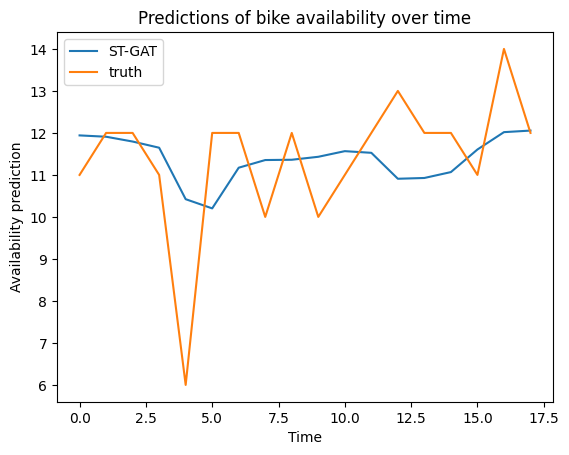

18


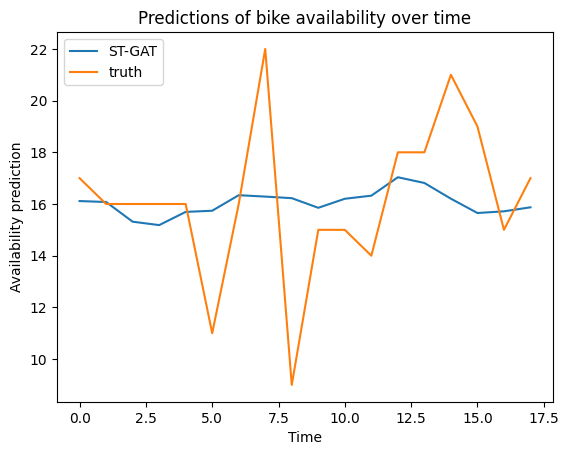

18


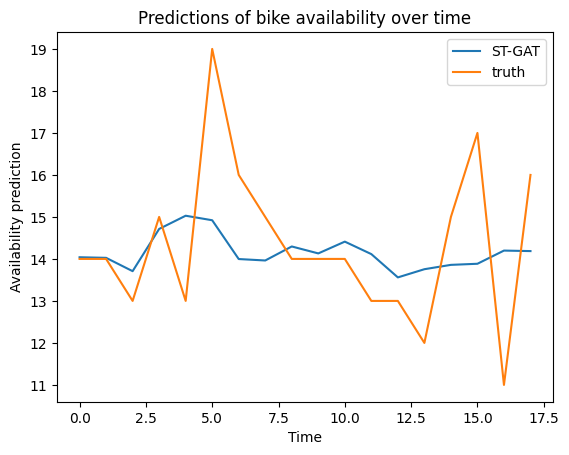

18


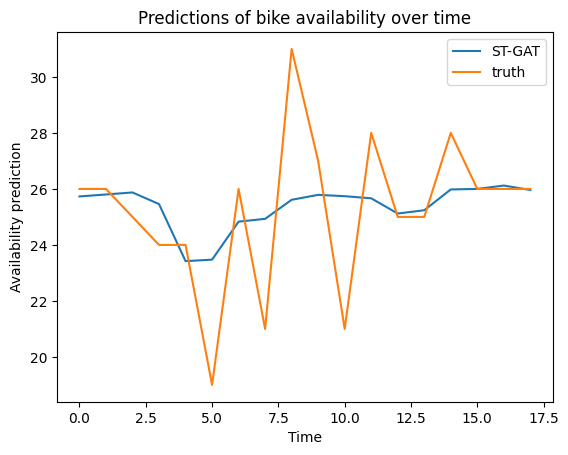

18


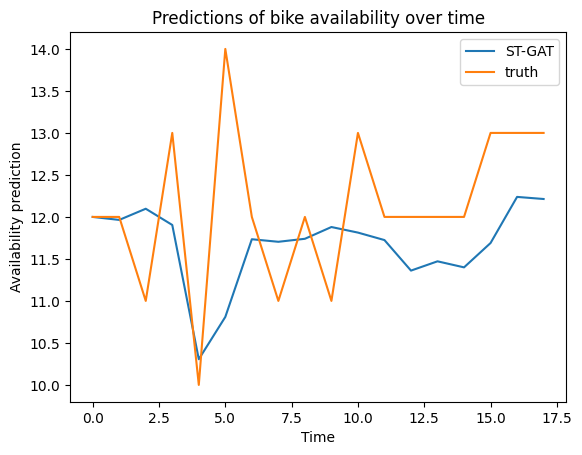

18


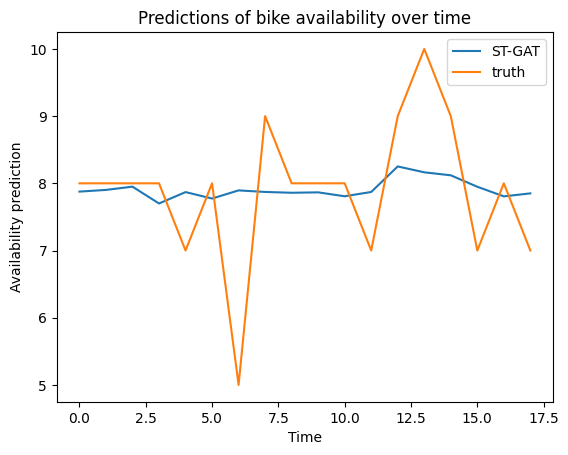

18


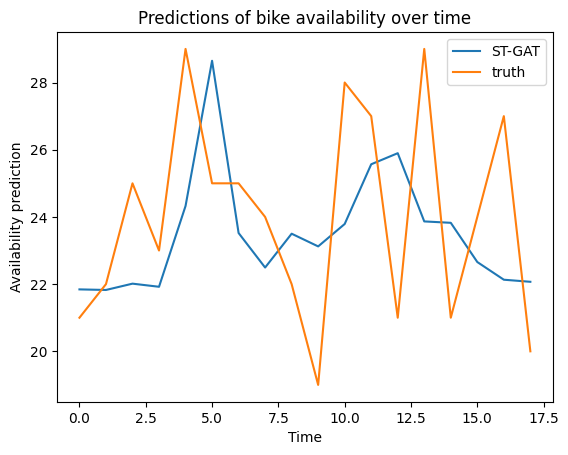

18


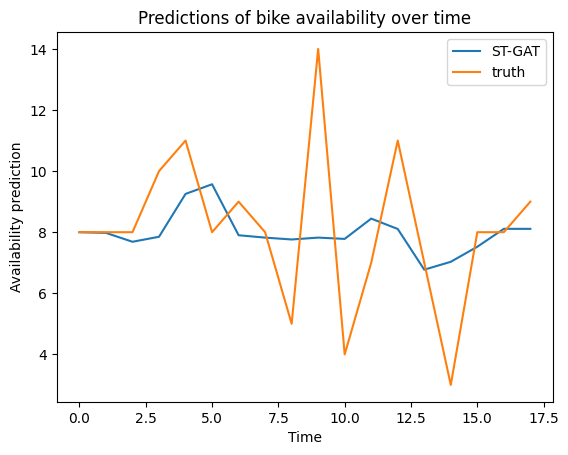

18


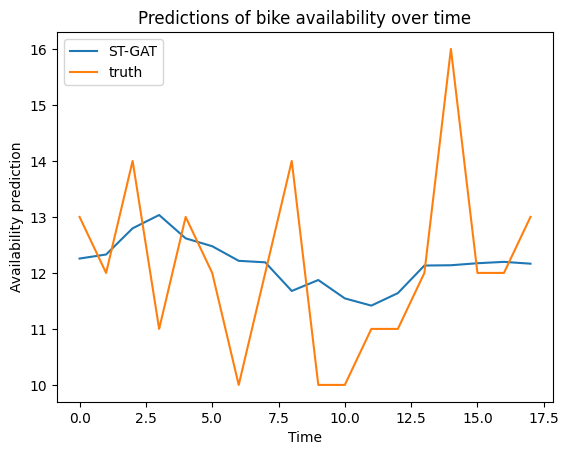

18


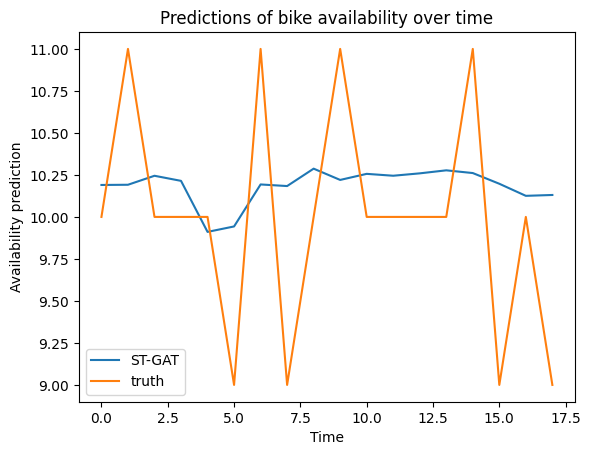

In [ ]:
temp=y_truth
temp2=y_pred
y_truth=temp
y_pred=temp2

for i in range(20,30):
  plot_prediction(y_truth,y_pred,i,config)

## Trying with different parameters

In [ ]:
N_PRED=1
N_HIST=2
batch_size=32
epochs=300

In [ ]:
# define new config:
config = {
    'BATCH_SIZE': batch_size,
    'EPOCHS': epochs,
    'WEIGHT_DECAY': 5e-5,
    'INITIAL_LR': 1e-3,
    'CHECKPOINT_DIR': './runs',
    'N_PRED': N_PRED, # number of hours in advance to predict
    'N_HIST': N_HIST, # number of past hours to use for prediction
    'DROPOUT': 0.2,
    # number of possible 1 hour measurements per day
    'N_DAY_SLOT': 24,
    # number of days worth of data in the dataset
    'N_DAYS': 31,
    # If false, use GCN paper weight matrix, if true, use GAT paper weight matrix
    'USE_GAT_WEIGHTS': True,
    'N_NODE': distances.shape[0],
}
# Number of possible windows in a day
config['N_SLOT']= config['N_DAY_SLOT'] - (config['N_PRED']+config['N_HIST']) + 1

# Load the dataset
dataset = BikeshareDataset(config, W, process_new_name=f'{N_PRED}_{N_HIST}_{batch_size}_{epochs}')


Processing...
Done!


In [ ]:

# create dataloaders
train_data, val_data, test_data = get_splits(dataset, config['N_SLOT'], (25, 3, 3))
train_dataloader = DataLoader(train_data, batch_size=config['BATCH_SIZE'], shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=config['BATCH_SIZE'], shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=config['BATCH_SIZE'], shuffle=False)

In [ ]:
model = model_train(train_dataloader, val_dataloader, config, device)

Epoch 0: 100%|██████████| 18/18 [00:01<00:00,  9.51it/s]


Loss: 0.835
Train, MAE: 1.9846854209899902, RMSE: 3.0222368240356445, MAPE: 20.58087921142578
Valid, MAE: 2.069749116897583, RMSE: 3.122260093688965, MAPE: 21.64019775390625


Epoch 1: 100%|██████████| 18/18 [00:01<00:00, 13.43it/s]


Loss: 0.260


Epoch 2: 100%|██████████| 18/18 [00:01<00:00, 13.24it/s]


Loss: 0.151


Epoch 3: 100%|██████████| 18/18 [00:01<00:00, 13.40it/s]


Loss: 0.046


Epoch 4: 100%|██████████| 18/18 [00:01<00:00,  9.70it/s]


Loss: 0.109


Epoch 5: 100%|██████████| 18/18 [00:02<00:00,  8.74it/s]


Loss: 0.100
Train, MAE: 0.5097669363021851, RMSE: 1.028547763824463, MAPE: 5.509409427642822
Valid, MAE: 0.6504020690917969, RMSE: 1.2266290187835693, MAPE: 7.400308609008789


Epoch 6: 100%|██████████| 18/18 [00:01<00:00, 10.00it/s]


Loss: 0.107


Epoch 7: 100%|██████████| 18/18 [00:01<00:00, 13.37it/s]


Loss: 0.049


Epoch 8: 100%|██████████| 18/18 [00:01<00:00, 13.56it/s]


Loss: 0.084


Epoch 9: 100%|██████████| 18/18 [00:01<00:00, 12.34it/s]


Loss: 0.086


Epoch 10: 100%|██████████| 18/18 [00:01<00:00, 13.37it/s]


Loss: 0.061
Train, MAE: 0.5068682432174683, RMSE: 1.0253310203552246, MAPE: 5.488707542419434
Valid, MAE: 0.5299670696258545, RMSE: 1.0478132963180542, MAPE: 5.82224702835083


Epoch 11: 100%|██████████| 18/18 [00:01<00:00, 13.67it/s]


Loss: 0.053


Epoch 12: 100%|██████████| 18/18 [00:01<00:00, 13.31it/s]


Loss: 0.105


Epoch 13: 100%|██████████| 18/18 [00:01<00:00, 10.71it/s]


Loss: 0.093


Epoch 14: 100%|██████████| 18/18 [00:02<00:00,  8.60it/s]


Loss: 0.048


Epoch 15: 100%|██████████| 18/18 [00:02<00:00,  8.66it/s]


Loss: 0.064
Train, MAE: 0.4884413480758667, RMSE: 1.0019605159759521, MAPE: 5.250336647033691
Valid, MAE: 0.644509494304657, RMSE: 1.1940665245056152, MAPE: 7.172057628631592


Epoch 16: 100%|██████████| 18/18 [00:01<00:00, 13.76it/s]


Loss: 0.111


Epoch 17: 100%|██████████| 18/18 [00:01<00:00, 13.44it/s]


Loss: 0.075


Epoch 18: 100%|██████████| 18/18 [00:01<00:00, 13.46it/s]


Loss: 0.068


Epoch 19: 100%|██████████| 18/18 [00:01<00:00, 13.52it/s]


Loss: 0.069


Epoch 20: 100%|██████████| 18/18 [00:01<00:00, 13.37it/s]


Loss: 0.181
Train, MAE: 0.4984246790409088, RMSE: 1.003733515739441, MAPE: 5.364461898803711
Valid, MAE: 0.8146058917045593, RMSE: 1.5152047872543335, MAPE: 9.983952522277832


Epoch 21: 100%|██████████| 18/18 [00:01<00:00, 13.59it/s]


Loss: 0.055


Epoch 22: 100%|██████████| 18/18 [00:01<00:00, 12.84it/s]


Loss: 0.066


Epoch 23: 100%|██████████| 18/18 [00:02<00:00,  8.79it/s]


Loss: 0.067


Epoch 24: 100%|██████████| 18/18 [00:02<00:00,  8.56it/s]


Loss: 0.043


Epoch 25: 100%|██████████| 18/18 [00:01<00:00,  9.22it/s]


Loss: 0.049
Train, MAE: 0.4984181225299835, RMSE: 1.0066936016082764, MAPE: 5.381972312927246
Valid, MAE: 0.6808826923370361, RMSE: 1.2564038038253784, MAPE: 7.766304016113281


Epoch 26: 100%|██████████| 18/18 [00:01<00:00, 13.42it/s]


Loss: 0.077


Epoch 27: 100%|██████████| 18/18 [00:01<00:00, 13.51it/s]


Loss: 0.091


Epoch 28: 100%|██████████| 18/18 [00:01<00:00, 13.64it/s]


Loss: 0.049


Epoch 29: 100%|██████████| 18/18 [00:01<00:00, 13.29it/s]


Loss: 0.143


Epoch 30: 100%|██████████| 18/18 [00:01<00:00, 13.75it/s]


Loss: 0.044
Train, MAE: 0.4954153299331665, RMSE: 0.9944060444831848, MAPE: 5.324993133544922
Valid, MAE: 0.5773255228996277, RMSE: 1.08472740650177, MAPE: 6.404616832733154


Epoch 31: 100%|██████████| 18/18 [00:01<00:00, 13.06it/s]


Loss: 0.061


Epoch 32: 100%|██████████| 18/18 [00:02<00:00,  8.90it/s]


Loss: 0.089


Epoch 33: 100%|██████████| 18/18 [00:02<00:00,  8.62it/s]


Loss: 0.078


Epoch 34: 100%|██████████| 18/18 [00:01<00:00,  9.04it/s]


Loss: 0.047


Epoch 35: 100%|██████████| 18/18 [00:01<00:00,  9.31it/s]


Loss: 0.100
Train, MAE: 0.49467527866363525, RMSE: 1.0094585418701172, MAPE: 5.3285417556762695
Valid, MAE: 0.6803423762321472, RMSE: 1.2506572008132935, MAPE: 7.758215427398682


Epoch 36: 100%|██████████| 18/18 [00:01<00:00, 13.63it/s]


Loss: 0.075


Epoch 37: 100%|██████████| 18/18 [00:01<00:00, 13.43it/s]


Loss: 0.075


Epoch 38: 100%|██████████| 18/18 [00:01<00:00, 13.58it/s]


Loss: 0.063


Epoch 39: 100%|██████████| 18/18 [00:01<00:00, 13.66it/s]


Loss: 0.102


Epoch 40: 100%|██████████| 18/18 [00:01<00:00, 12.95it/s]


Loss: 0.056
Train, MAE: 0.4959352910518646, RMSE: 1.0039745569229126, MAPE: 5.335527420043945
Valid, MAE: 0.633532702922821, RMSE: 1.1902340650558472, MAPE: 6.842692852020264


Epoch 41: 100%|██████████| 18/18 [00:02<00:00,  8.72it/s]


Loss: 0.060


Epoch 42: 100%|██████████| 18/18 [00:02<00:00,  8.58it/s]


Loss: 0.069


Epoch 43: 100%|██████████| 18/18 [00:01<00:00, 11.21it/s]


Loss: 0.092


Epoch 44: 100%|██████████| 18/18 [00:01<00:00, 13.60it/s]


Loss: 0.086


Epoch 45: 100%|██████████| 18/18 [00:01<00:00, 13.49it/s]


Loss: 0.105
Train, MAE: 0.49185433983802795, RMSE: 1.003206491470337, MAPE: 5.298750877380371
Valid, MAE: 0.6627834439277649, RMSE: 1.2438846826553345, MAPE: 7.116539478302002


Epoch 46: 100%|██████████| 18/18 [00:01<00:00, 13.48it/s]


Loss: 0.074


Epoch 47: 100%|██████████| 18/18 [00:01<00:00, 13.49it/s]


Loss: 0.055


Epoch 48: 100%|██████████| 18/18 [00:01<00:00, 13.48it/s]


Loss: 0.043


Epoch 49: 100%|██████████| 18/18 [00:01<00:00, 13.39it/s]


Loss: 0.128


Epoch 50: 100%|██████████| 18/18 [00:01<00:00, 10.01it/s]


Loss: 0.066
Train, MAE: 0.4867037236690521, RMSE: 0.9491478800773621, MAPE: 5.2300944328308105
Valid, MAE: 0.5789229869842529, RMSE: 1.1296979188919067, MAPE: 6.41555643081665


Epoch 51: 100%|██████████| 18/18 [00:02<00:00,  8.74it/s]


Loss: 0.079


Epoch 52: 100%|██████████| 18/18 [00:01<00:00,  9.38it/s]


Loss: 0.082


Epoch 53: 100%|██████████| 18/18 [00:01<00:00, 13.62it/s]


Loss: 0.058


Epoch 54: 100%|██████████| 18/18 [00:01<00:00, 13.14it/s]


Loss: 0.081


Epoch 55: 100%|██████████| 18/18 [00:01<00:00, 13.64it/s]


Loss: 0.062
Train, MAE: 0.47316673398017883, RMSE: 0.9342532753944397, MAPE: 5.1002936363220215
Valid, MAE: 0.5766959190368652, RMSE: 1.146854043006897, MAPE: 6.298976898193359


Epoch 56: 100%|██████████| 18/18 [00:01<00:00, 13.33it/s]


Loss: 0.088


Epoch 57: 100%|██████████| 18/18 [00:01<00:00, 13.62it/s]


Loss: 0.044


Epoch 58: 100%|██████████| 18/18 [00:01<00:00, 13.51it/s]


Loss: 0.091


Epoch 59: 100%|██████████| 18/18 [00:01<00:00, 11.56it/s]


Loss: 0.078


Epoch 60: 100%|██████████| 18/18 [00:02<00:00,  8.34it/s]


Loss: 0.062
Train, MAE: 0.4750317931175232, RMSE: 0.9314647316932678, MAPE: 5.123343467712402
Valid, MAE: 0.5004478693008423, RMSE: 0.9866852760314941, MAPE: 5.553523540496826


Epoch 61: 100%|██████████| 18/18 [00:01<00:00, 12.38it/s]


Loss: 0.063


Epoch 62: 100%|██████████| 18/18 [00:01<00:00, 13.43it/s]


Loss: 0.064


Epoch 63: 100%|██████████| 18/18 [00:01<00:00, 13.45it/s]


Loss: 0.071


Epoch 64: 100%|██████████| 18/18 [00:01<00:00, 13.47it/s]


Loss: 0.044


Epoch 65: 100%|██████████| 18/18 [00:01<00:00, 13.53it/s]


Loss: 0.094
Train, MAE: 0.480864942073822, RMSE: 0.9333779215812683, MAPE: 5.182364463806152
Valid, MAE: 0.6580972671508789, RMSE: 1.246294379234314, MAPE: 7.313157558441162


Epoch 66: 100%|██████████| 18/18 [00:01<00:00, 13.69it/s]


Loss: 0.084


Epoch 67: 100%|██████████| 18/18 [00:01<00:00, 13.39it/s]


Loss: 0.094


Epoch 68: 100%|██████████| 18/18 [00:01<00:00,  9.29it/s]


Loss: 0.099


Epoch 69: 100%|██████████| 18/18 [00:02<00:00,  8.69it/s]


Loss: 0.054


Epoch 70: 100%|██████████| 18/18 [00:02<00:00,  8.61it/s]


Loss: 0.076
Train, MAE: 0.46962621808052063, RMSE: 0.9049654006958008, MAPE: 5.057526588439941
Valid, MAE: 0.5337867140769958, RMSE: 1.026045799255371, MAPE: 5.877640247344971


Epoch 71: 100%|██████████| 18/18 [00:01<00:00, 13.33it/s]


Loss: 0.099


Epoch 72: 100%|██████████| 18/18 [00:01<00:00, 13.56it/s]


Loss: 0.038


Epoch 73: 100%|██████████| 18/18 [00:01<00:00, 13.42it/s]


Loss: 0.062


Epoch 74: 100%|██████████| 18/18 [00:01<00:00, 13.66it/s]


Loss: 0.094


Epoch 75: 100%|██████████| 18/18 [00:01<00:00, 13.45it/s]


Loss: 0.038
Train, MAE: 0.4761945903301239, RMSE: 0.8989625573158264, MAPE: 5.155446529388428
Valid, MAE: 0.5888614058494568, RMSE: 1.0792781114578247, MAPE: 6.434323787689209


Epoch 76: 100%|██████████| 18/18 [00:01<00:00, 13.57it/s]


Loss: 0.057


Epoch 77: 100%|██████████| 18/18 [00:01<00:00, 11.24it/s]


Loss: 0.076


Epoch 78: 100%|██████████| 18/18 [00:02<00:00,  8.69it/s]


Loss: 0.077


Epoch 79: 100%|██████████| 18/18 [00:02<00:00,  8.74it/s]


Loss: 0.087


Epoch 80: 100%|██████████| 18/18 [00:01<00:00, 10.45it/s]


Loss: 0.085
Train, MAE: 0.4571200907230377, RMSE: 0.8835036158561707, MAPE: 4.914802551269531
Valid, MAE: 0.5833415389060974, RMSE: 1.073759913444519, MAPE: 6.34257173538208


Epoch 81: 100%|██████████| 18/18 [00:01<00:00, 13.50it/s]


Loss: 0.036


Epoch 82: 100%|██████████| 18/18 [00:01<00:00, 13.57it/s]


Loss: 0.050


Epoch 83: 100%|██████████| 18/18 [00:01<00:00, 13.43it/s]


Loss: 0.072


Epoch 84: 100%|██████████| 18/18 [00:01<00:00, 13.42it/s]


Loss: 0.082


Epoch 85: 100%|██████████| 18/18 [00:01<00:00, 13.45it/s]


Loss: 0.075
Train, MAE: 0.4642639756202698, RMSE: 0.8801065683364868, MAPE: 5.038722038269043
Valid, MAE: 0.6128985285758972, RMSE: 1.175838589668274, MAPE: 7.049229145050049


Epoch 86: 100%|██████████| 18/18 [00:01<00:00, 13.34it/s]


Loss: 0.093


Epoch 87: 100%|██████████| 18/18 [00:02<00:00,  8.80it/s]


Loss: 0.076


Epoch 88: 100%|██████████| 18/18 [00:02<00:00,  8.53it/s]


Loss: 0.048


Epoch 89: 100%|██████████| 18/18 [00:02<00:00,  8.97it/s]


Loss: 0.065


Epoch 90: 100%|██████████| 18/18 [00:01<00:00, 13.48it/s]


Loss: 0.056
Train, MAE: 0.45952728390693665, RMSE: 0.8814464807510376, MAPE: 4.976800918579102
Valid, MAE: 0.6863202452659607, RMSE: 1.2764544486999512, MAPE: 7.488919734954834


Epoch 91: 100%|██████████| 18/18 [00:01<00:00, 13.55it/s]


Loss: 0.074


Epoch 92: 100%|██████████| 18/18 [00:01<00:00, 13.72it/s]


Loss: 0.051


Epoch 93: 100%|██████████| 18/18 [00:01<00:00, 13.46it/s]


Loss: 0.091


Epoch 94: 100%|██████████| 18/18 [00:01<00:00, 13.59it/s]


Loss: 0.060


Epoch 95: 100%|██████████| 18/18 [00:01<00:00, 13.62it/s]


Loss: 0.030
Train, MAE: 0.45469945669174194, RMSE: 0.8734294176101685, MAPE: 4.920192718505859
Valid, MAE: 0.517690122127533, RMSE: 0.9859068989753723, MAPE: 5.750074863433838


Epoch 96: 100%|██████████| 18/18 [00:01<00:00,  9.97it/s]


Loss: 0.086


Epoch 97: 100%|██████████| 18/18 [00:02<00:00,  8.64it/s]


Loss: 0.074


Epoch 98: 100%|██████████| 18/18 [00:02<00:00,  8.38it/s]


Loss: 0.062


Epoch 99: 100%|██████████| 18/18 [00:01<00:00, 12.29it/s]


Loss: 0.068


Epoch 100: 100%|██████████| 18/18 [00:01<00:00, 13.62it/s]


Loss: 0.083
Train, MAE: 0.4613973796367645, RMSE: 0.8768999576568604, MAPE: 4.95399284362793
Valid, MAE: 0.5938766598701477, RMSE: 1.1554313898086548, MAPE: 6.772688388824463


Epoch 101: 100%|██████████| 18/18 [00:01<00:00, 13.63it/s]


Loss: 0.106


Epoch 102: 100%|██████████| 18/18 [00:01<00:00, 13.56it/s]


Loss: 0.071


Epoch 103: 100%|██████████| 18/18 [00:01<00:00, 13.44it/s]


Loss: 0.079


Epoch 104: 100%|██████████| 18/18 [00:01<00:00, 13.37it/s]


Loss: 0.103


Epoch 105: 100%|██████████| 18/18 [00:01<00:00, 13.44it/s]


Loss: 0.029
Train, MAE: 0.4564895033836365, RMSE: 0.870518147945404, MAPE: 4.925741195678711
Valid, MAE: 0.5681217312812805, RMSE: 1.0783497095108032, MAPE: 6.229955673217773


Epoch 106: 100%|██████████| 18/18 [00:02<00:00,  8.65it/s]


Loss: 0.072


Epoch 107: 100%|██████████| 18/18 [00:02<00:00,  8.90it/s]


Loss: 0.057


Epoch 108: 100%|██████████| 18/18 [00:01<00:00,  9.73it/s]


Loss: 0.084


Epoch 109: 100%|██████████| 18/18 [00:01<00:00, 13.53it/s]


Loss: 0.054


Epoch 110: 100%|██████████| 18/18 [00:01<00:00, 13.60it/s]


Loss: 0.063
Train, MAE: 0.4556432366371155, RMSE: 0.8633813261985779, MAPE: 4.913504123687744
Valid, MAE: 0.5079267621040344, RMSE: 0.9764919281005859, MAPE: 5.593638896942139


Epoch 111: 100%|██████████| 18/18 [00:01<00:00, 13.73it/s]


Loss: 0.072


Epoch 112: 100%|██████████| 18/18 [00:01<00:00, 13.47it/s]


Loss: 0.048


Epoch 113: 100%|██████████| 18/18 [00:01<00:00, 13.61it/s]


Loss: 0.089


Epoch 114: 100%|██████████| 18/18 [00:01<00:00, 13.49it/s]


Loss: 0.072


Epoch 115: 100%|██████████| 18/18 [00:01<00:00, 11.37it/s]


Loss: 0.048
Train, MAE: 0.463228702545166, RMSE: 0.8766514658927917, MAPE: 5.015501499176025
Valid, MAE: 0.6297438740730286, RMSE: 1.121935486793518, MAPE: 7.0688252449035645


Epoch 116: 100%|██████████| 18/18 [00:02<00:00,  8.79it/s]


Loss: 0.040


Epoch 117: 100%|██████████| 18/18 [00:02<00:00,  8.52it/s]


Loss: 0.064


Epoch 118: 100%|██████████| 18/18 [00:01<00:00, 12.53it/s]


Loss: 0.074


Epoch 119: 100%|██████████| 18/18 [00:01<00:00, 13.48it/s]


Loss: 0.042


Epoch 120: 100%|██████████| 18/18 [00:01<00:00, 13.71it/s]


Loss: 0.069
Train, MAE: 0.44451481103897095, RMSE: 0.8527898788452148, MAPE: 4.792283058166504
Valid, MAE: 0.5504792928695679, RMSE: 1.0183461904525757, MAPE: 6.1438212394714355


Epoch 121: 100%|██████████| 18/18 [00:01<00:00, 13.38it/s]


Loss: 0.096


Epoch 122: 100%|██████████| 18/18 [00:01<00:00, 13.33it/s]


Loss: 0.083


Epoch 123: 100%|██████████| 18/18 [00:01<00:00, 13.55it/s]


Loss: 0.055


Epoch 124: 100%|██████████| 18/18 [00:01<00:00, 13.45it/s]


Loss: 0.071


Epoch 125: 100%|██████████| 18/18 [00:02<00:00,  8.91it/s]


Loss: 0.086
Train, MAE: 0.4491896629333496, RMSE: 0.8564167022705078, MAPE: 4.873467922210693
Valid, MAE: 0.5951102375984192, RMSE: 1.091154932975769, MAPE: 6.695037841796875


Epoch 126: 100%|██████████| 18/18 [00:02<00:00,  8.62it/s]


Loss: 0.080


Epoch 127: 100%|██████████| 18/18 [00:01<00:00, 10.26it/s]


Loss: 0.108


Epoch 128: 100%|██████████| 18/18 [00:01<00:00, 13.21it/s]


Loss: 0.052


Epoch 129: 100%|██████████| 18/18 [00:01<00:00, 13.37it/s]


Loss: 0.098


Epoch 130: 100%|██████████| 18/18 [00:01<00:00, 13.19it/s]


Loss: 0.053
Train, MAE: 0.44832563400268555, RMSE: 0.8596540689468384, MAPE: 4.842291831970215
Valid, MAE: 0.558225154876709, RMSE: 1.0548139810562134, MAPE: 6.207696914672852


Epoch 131: 100%|██████████| 18/18 [00:01<00:00, 13.26it/s]


Loss: 0.066


Epoch 132: 100%|██████████| 18/18 [00:01<00:00, 13.25it/s]


Loss: 0.058


Epoch 133: 100%|██████████| 18/18 [00:01<00:00, 13.22it/s]


Loss: 0.050


Epoch 134: 100%|██████████| 18/18 [00:01<00:00,  9.83it/s]


Loss: 0.055


Epoch 135: 100%|██████████| 18/18 [00:02<00:00,  8.50it/s]


Loss: 0.084
Train, MAE: 0.4485071897506714, RMSE: 0.8516350388526917, MAPE: 4.831202983856201
Valid, MAE: 0.6584898829460144, RMSE: 1.2090367078781128, MAPE: 7.3143768310546875


Epoch 136: 100%|██████████| 18/18 [00:01<00:00,  9.48it/s]


Loss: 0.046


Epoch 137: 100%|██████████| 18/18 [00:01<00:00, 13.15it/s]


Loss: 0.060


Epoch 138: 100%|██████████| 18/18 [00:01<00:00, 13.40it/s]


Loss: 0.071


Epoch 139: 100%|██████████| 18/18 [00:01<00:00, 13.09it/s]


Loss: 0.109


Epoch 140: 100%|██████████| 18/18 [00:01<00:00, 13.12it/s]


Loss: 0.042
Train, MAE: 0.45185449719429016, RMSE: 0.8584420084953308, MAPE: 4.868946075439453
Valid, MAE: 0.576407253742218, RMSE: 1.0694833993911743, MAPE: 6.365347385406494


Epoch 141: 100%|██████████| 18/18 [00:01<00:00, 13.18it/s]


Loss: 0.089


Epoch 142: 100%|██████████| 18/18 [00:01<00:00, 13.20it/s]


Loss: 0.068


Epoch 143: 100%|██████████| 18/18 [00:01<00:00, 10.53it/s]


Loss: 0.048


Epoch 144: 100%|██████████| 18/18 [00:02<00:00,  8.60it/s]


Loss: 0.040


Epoch 145: 100%|██████████| 18/18 [00:02<00:00,  8.48it/s]


Loss: 0.049
Train, MAE: 0.44706991314888, RMSE: 0.8489978313446045, MAPE: 4.839205741882324
Valid, MAE: 0.6386136412620544, RMSE: 1.1527655124664307, MAPE: 7.1297926902771


Epoch 146: 100%|██████████| 18/18 [00:01<00:00, 13.44it/s]


Loss: 0.074


Epoch 147: 100%|██████████| 18/18 [00:01<00:00, 13.23it/s]


Loss: 0.049


Epoch 148: 100%|██████████| 18/18 [00:01<00:00, 13.40it/s]


Loss: 0.105


Epoch 149: 100%|██████████| 18/18 [00:01<00:00, 13.52it/s]


Loss: 0.061


Epoch 150: 100%|██████████| 18/18 [00:01<00:00, 13.35it/s]


Loss: 0.082
Train, MAE: 0.4533371329307556, RMSE: 0.8516285419464111, MAPE: 4.876867771148682
Valid, MAE: 0.6313782930374146, RMSE: 1.1545085906982422, MAPE: 6.9541335105896


Epoch 151: 100%|██████████| 18/18 [00:01<00:00, 13.57it/s]


Loss: 0.067


Epoch 152: 100%|██████████| 18/18 [00:01<00:00, 12.34it/s]


Loss: 0.067


Epoch 153: 100%|██████████| 18/18 [00:02<00:00,  8.68it/s]


Loss: 0.098


Epoch 154: 100%|██████████| 18/18 [00:02<00:00,  8.52it/s]


Loss: 0.025


Epoch 155: 100%|██████████| 18/18 [00:01<00:00,  9.51it/s]


Loss: 0.069
Train, MAE: 0.4516485035419464, RMSE: 0.8507004380226135, MAPE: 4.885557174682617
Valid, MAE: 0.6266803741455078, RMSE: 1.1714919805526733, MAPE: 7.067609786987305


Epoch 156: 100%|██████████| 18/18 [00:01<00:00, 13.30it/s]


Loss: 0.066


Epoch 157: 100%|██████████| 18/18 [00:01<00:00, 13.63it/s]


Loss: 0.070


Epoch 158: 100%|██████████| 18/18 [00:01<00:00, 13.55it/s]


Loss: 0.072


Epoch 159: 100%|██████████| 18/18 [00:01<00:00, 13.35it/s]


Loss: 0.044


Epoch 160: 100%|██████████| 18/18 [00:01<00:00, 13.44it/s]


Loss: 0.066
Train, MAE: 0.4368270933628082, RMSE: 0.8391955494880676, MAPE: 4.730947494506836
Valid, MAE: 0.7200775146484375, RMSE: 1.2735300064086914, MAPE: 8.161452293395996


Epoch 161: 100%|██████████| 18/18 [00:01<00:00, 13.44it/s]


Loss: 0.064


Epoch 162: 100%|██████████| 18/18 [00:01<00:00,  9.59it/s]


Loss: 0.044


Epoch 163: 100%|██████████| 18/18 [00:02<00:00,  8.91it/s]


Loss: 0.069


Epoch 164: 100%|██████████| 18/18 [00:02<00:00,  8.74it/s]


Loss: 0.050


Epoch 165: 100%|██████████| 18/18 [00:01<00:00, 11.77it/s]


Loss: 0.050
Train, MAE: 0.44010964035987854, RMSE: 0.8446307182312012, MAPE: 4.751070976257324
Valid, MAE: 0.6124628186225891, RMSE: 1.1121244430541992, MAPE: 6.777638912200928


Epoch 166: 100%|██████████| 18/18 [00:01<00:00, 13.42it/s]


Loss: 0.082


Epoch 167: 100%|██████████| 18/18 [00:01<00:00, 13.48it/s]


Loss: 0.037


Epoch 168: 100%|██████████| 18/18 [00:01<00:00, 13.60it/s]


Loss: 0.065


Epoch 169: 100%|██████████| 18/18 [00:01<00:00, 13.36it/s]


Loss: 0.081


Epoch 170: 100%|██████████| 18/18 [00:01<00:00, 13.48it/s]


Loss: 0.068
Train, MAE: 0.447388231754303, RMSE: 0.8478002548217773, MAPE: 4.868291854858398
Valid, MAE: 0.6186128258705139, RMSE: 1.1248817443847656, MAPE: 6.9262566566467285


Epoch 171: 100%|██████████| 18/18 [00:01<00:00, 11.89it/s]


Loss: 0.045


Epoch 172: 100%|██████████| 18/18 [00:02<00:00,  8.90it/s]


Loss: 0.075


Epoch 173: 100%|██████████| 18/18 [00:02<00:00,  6.85it/s]


Loss: 0.081


Epoch 174: 100%|██████████| 18/18 [00:02<00:00,  6.76it/s]


Loss: 0.079


Epoch 175: 100%|██████████| 18/18 [00:01<00:00, 11.60it/s]


Loss: 0.033
Train, MAE: 0.43652164936065674, RMSE: 0.8385344743728638, MAPE: 4.730627059936523
Valid, MAE: 0.5572752356529236, RMSE: 1.0265969038009644, MAPE: 6.247495174407959


Epoch 176: 100%|██████████| 18/18 [00:02<00:00,  8.77it/s]


Loss: 0.081


Epoch 177: 100%|██████████| 18/18 [00:01<00:00,  9.24it/s]


Loss: 0.045


Epoch 178: 100%|██████████| 18/18 [00:01<00:00, 13.55it/s]


Loss: 0.033


Epoch 179: 100%|██████████| 18/18 [00:01<00:00, 13.28it/s]


Loss: 0.076


Epoch 180: 100%|██████████| 18/18 [00:01<00:00, 11.31it/s]


Loss: 0.086
Train, MAE: 0.44483184814453125, RMSE: 0.8423407077789307, MAPE: 4.821253776550293
Valid, MAE: 0.5501113533973694, RMSE: 1.0431174039840698, MAPE: 6.021708965301514


Epoch 181: 100%|██████████| 18/18 [00:02<00:00,  8.80it/s]


Loss: 0.071


Epoch 182: 100%|██████████| 18/18 [00:02<00:00,  8.73it/s]


Loss: 0.042


Epoch 183: 100%|██████████| 18/18 [00:01<00:00, 12.33it/s]


Loss: 0.056


Epoch 184: 100%|██████████| 18/18 [00:01<00:00, 13.40it/s]


Loss: 0.045


Epoch 185: 100%|██████████| 18/18 [00:01<00:00, 13.31it/s]


Loss: 0.049
Train, MAE: 0.43511974811553955, RMSE: 0.8297600746154785, MAPE: 4.706925392150879
Valid, MAE: 0.6262877583503723, RMSE: 1.1493626832962036, MAPE: 6.925085544586182


Epoch 186: 100%|██████████| 18/18 [00:01<00:00, 13.07it/s]


Loss: 0.054


Epoch 187: 100%|██████████| 18/18 [00:01<00:00, 13.23it/s]


Loss: 0.066


Epoch 188: 100%|██████████| 18/18 [00:01<00:00, 13.37it/s]


Loss: 0.054


Epoch 189: 100%|██████████| 18/18 [00:01<00:00, 13.08it/s]


Loss: 0.067


Epoch 190: 100%|██████████| 18/18 [00:02<00:00,  8.40it/s]


Loss: 0.066
Train, MAE: 0.4347935914993286, RMSE: 0.8304509520530701, MAPE: 4.716671943664551
Valid, MAE: 0.5452125072479248, RMSE: 1.0273373126983643, MAPE: 6.098236083984375


Epoch 191: 100%|██████████| 18/18 [00:02<00:00,  8.67it/s]


Loss: 0.045


Epoch 192: 100%|██████████| 18/18 [00:01<00:00, 10.72it/s]


Loss: 0.072


Epoch 193: 100%|██████████| 18/18 [00:01<00:00, 13.19it/s]


Loss: 0.061


Epoch 194: 100%|██████████| 18/18 [00:01<00:00, 13.36it/s]


Loss: 0.062


Epoch 195: 100%|██████████| 18/18 [00:01<00:00, 12.43it/s]


Loss: 0.051
Train, MAE: 0.44121238589286804, RMSE: 0.8344883918762207, MAPE: 4.778148174285889
Valid, MAE: 0.6181644797325134, RMSE: 1.1098856925964355, MAPE: 6.754678726196289


Epoch 196: 100%|██████████| 18/18 [00:02<00:00,  8.65it/s]


Loss: 0.028


Epoch 197: 100%|██████████| 18/18 [00:02<00:00,  8.42it/s]


Loss: 0.077


Epoch 198: 100%|██████████| 18/18 [00:02<00:00,  7.40it/s]


Loss: 0.030


Epoch 199: 100%|██████████| 18/18 [00:02<00:00,  8.45it/s]


Loss: 0.046


Epoch 200: 100%|██████████| 18/18 [00:02<00:00,  8.55it/s]


Loss: 0.071
Train, MAE: 0.44299831986427307, RMSE: 0.8338792324066162, MAPE: 4.786988735198975
Valid, MAE: 0.5335552096366882, RMSE: 1.0074771642684937, MAPE: 5.895175933837891


Epoch 201: 100%|██████████| 18/18 [00:01<00:00, 13.49it/s]


Loss: 0.065


Epoch 202: 100%|██████████| 18/18 [00:01<00:00, 13.41it/s]


Loss: 0.054


Epoch 203: 100%|██████████| 18/18 [00:01<00:00, 13.40it/s]


Loss: 0.056


Epoch 204: 100%|██████████| 18/18 [00:01<00:00, 13.36it/s]


Loss: 0.109


Epoch 205: 100%|██████████| 18/18 [00:01<00:00, 13.44it/s]


Loss: 0.056
Train, MAE: 0.4502286911010742, RMSE: 0.8443366289138794, MAPE: 4.888075828552246
Valid, MAE: 0.4764503240585327, RMSE: 0.9023594856262207, MAPE: 5.322864532470703


Epoch 206: 100%|██████████| 18/18 [00:01<00:00, 13.26it/s]


Loss: 0.076


Epoch 207: 100%|██████████| 18/18 [00:01<00:00, 11.84it/s]


Loss: 0.072


Epoch 208: 100%|██████████| 18/18 [00:02<00:00,  8.64it/s]


Loss: 0.059


Epoch 209: 100%|██████████| 18/18 [00:02<00:00,  8.51it/s]


Loss: 0.036


Epoch 210: 100%|██████████| 18/18 [00:01<00:00,  9.59it/s]


Loss: 0.057
Train, MAE: 0.43856215476989746, RMSE: 0.8340947031974792, MAPE: 4.7464599609375
Valid, MAE: 0.6082904934883118, RMSE: 1.1253591775894165, MAPE: 6.892202854156494


Epoch 211: 100%|██████████| 18/18 [00:01<00:00, 13.68it/s]


Loss: 0.042


Epoch 212: 100%|██████████| 18/18 [00:01<00:00, 13.14it/s]


Loss: 0.045


Epoch 213: 100%|██████████| 18/18 [00:01<00:00, 13.51it/s]


Loss: 0.055


Epoch 214: 100%|██████████| 18/18 [00:01<00:00, 13.28it/s]


Loss: 0.047


Epoch 215: 100%|██████████| 18/18 [00:01<00:00, 13.47it/s]


Loss: 0.084
Train, MAE: 0.4421289563179016, RMSE: 0.8327823877334595, MAPE: 4.789708614349365
Valid, MAE: 0.6071839928627014, RMSE: 1.1354269981384277, MAPE: 6.653210163116455


Epoch 216: 100%|██████████| 18/18 [00:01<00:00, 13.50it/s]


Loss: 0.053


Epoch 217: 100%|██████████| 18/18 [00:01<00:00,  9.12it/s]


Loss: 0.071


Epoch 218: 100%|██████████| 18/18 [00:02<00:00,  8.52it/s]


Loss: 0.048


Epoch 219: 100%|██████████| 18/18 [00:02<00:00,  8.57it/s]


Loss: 0.067


Epoch 220: 100%|██████████| 18/18 [00:01<00:00, 13.11it/s]


Loss: 0.073
Train, MAE: 0.4335950016975403, RMSE: 0.8278887271881104, MAPE: 4.69312858581543
Valid, MAE: 0.4477764070034027, RMSE: 0.8496808409690857, MAPE: 4.970142841339111


Epoch 221: 100%|██████████| 18/18 [00:01<00:00, 13.63it/s]


Loss: 0.101


Epoch 222: 100%|██████████| 18/18 [00:01<00:00, 13.40it/s]


Loss: 0.054


Epoch 223: 100%|██████████| 18/18 [00:01<00:00, 13.15it/s]


Loss: 0.084


Epoch 224: 100%|██████████| 18/18 [00:01<00:00, 13.20it/s]


Loss: 0.072


Epoch 225: 100%|██████████| 18/18 [00:01<00:00, 13.34it/s]


Loss: 0.071
Train, MAE: 0.43320298194885254, RMSE: 0.8291299939155579, MAPE: 4.704099178314209
Valid, MAE: 0.670623242855072, RMSE: 1.1925987005233765, MAPE: 7.651607513427734


Epoch 226: 100%|██████████| 18/18 [00:01<00:00, 10.57it/s]


Loss: 0.056


Epoch 227: 100%|██████████| 18/18 [00:02<00:00,  8.78it/s]


Loss: 0.074


Epoch 228: 100%|██████████| 18/18 [00:02<00:00,  8.85it/s]


Loss: 0.056


Epoch 229: 100%|██████████| 18/18 [00:01<00:00, 10.25it/s]


Loss: 0.072


Epoch 230: 100%|██████████| 18/18 [00:01<00:00, 13.28it/s]


Loss: 0.035
Train, MAE: 0.4325859248638153, RMSE: 0.830552339553833, MAPE: 4.692811965942383
Valid, MAE: 0.47378841042518616, RMSE: 0.8917403221130371, MAPE: 5.2739081382751465


Epoch 231: 100%|██████████| 18/18 [00:01<00:00, 13.23it/s]


Loss: 0.039


Epoch 232: 100%|██████████| 18/18 [00:01<00:00, 13.15it/s]


Loss: 0.051


Epoch 233: 100%|██████████| 18/18 [00:01<00:00, 13.47it/s]


Loss: 0.046


Epoch 234: 100%|██████████| 18/18 [00:01<00:00, 12.58it/s]


Loss: 0.081


Epoch 235: 100%|██████████| 18/18 [00:01<00:00, 13.10it/s]


Loss: 0.047
Train, MAE: 0.4359426498413086, RMSE: 0.8316299915313721, MAPE: 4.737077236175537
Valid, MAE: 0.6010370850563049, RMSE: 1.1671665906906128, MAPE: 6.700929641723633


Epoch 236: 100%|██████████| 18/18 [00:02<00:00,  8.43it/s]


Loss: 0.062


Epoch 237: 100%|██████████| 18/18 [00:02<00:00,  8.66it/s]


Loss: 0.059


Epoch 238: 100%|██████████| 18/18 [00:01<00:00,  9.68it/s]


Loss: 0.073


Epoch 239: 100%|██████████| 18/18 [00:01<00:00, 13.13it/s]


Loss: 0.060


Epoch 240: 100%|██████████| 18/18 [00:01<00:00, 13.19it/s]


Loss: 0.074
Train, MAE: 0.4312189817428589, RMSE: 0.8251810669898987, MAPE: 4.66536283493042
Valid, MAE: 0.5823487639427185, RMSE: 1.091233730316162, MAPE: 6.48737907409668


Epoch 241: 100%|██████████| 18/18 [00:01<00:00, 13.32it/s]


Loss: 0.046


Epoch 242: 100%|██████████| 18/18 [00:01<00:00, 13.41it/s]


Loss: 0.063


Epoch 243: 100%|██████████| 18/18 [00:01<00:00, 13.06it/s]


Loss: 0.117


Epoch 244: 100%|██████████| 18/18 [00:01<00:00, 12.95it/s]


Loss: 0.079


Epoch 245: 100%|██████████| 18/18 [00:01<00:00, 10.76it/s]


Loss: 0.048
Train, MAE: 0.4332820773124695, RMSE: 0.82559734582901, MAPE: 4.692109107971191
Valid, MAE: 0.6533177495002747, RMSE: 1.1732906103134155, MAPE: 7.249203205108643


Epoch 246: 100%|██████████| 18/18 [00:02<00:00,  8.46it/s]


Loss: 0.071


Epoch 247: 100%|██████████| 18/18 [00:02<00:00,  8.73it/s]


Loss: 0.062


Epoch 248: 100%|██████████| 18/18 [00:01<00:00, 13.24it/s]


Loss: 0.056


Epoch 249: 100%|██████████| 18/18 [00:01<00:00, 13.26it/s]


Loss: 0.066


Epoch 250: 100%|██████████| 18/18 [00:01<00:00, 13.07it/s]


Loss: 0.051
Train, MAE: 0.43170320987701416, RMSE: 0.8252541422843933, MAPE: 4.686811923980713
Valid, MAE: 0.5177111029624939, RMSE: 0.9856253266334534, MAPE: 5.720971584320068


Epoch 251: 100%|██████████| 18/18 [00:01<00:00, 13.44it/s]


Loss: 0.053


Epoch 252: 100%|██████████| 18/18 [00:01<00:00, 13.36it/s]


Loss: 0.050


Epoch 253: 100%|██████████| 18/18 [00:01<00:00, 13.21it/s]


Loss: 0.028


Epoch 254: 100%|██████████| 18/18 [00:01<00:00, 11.97it/s]


Loss: 0.074


Epoch 255: 100%|██████████| 18/18 [00:02<00:00,  8.61it/s]


Loss: 0.082
Train, MAE: 0.4333032965660095, RMSE: 0.8258747458457947, MAPE: 4.696626663208008
Valid, MAE: 0.7014837265014648, RMSE: 1.2309389114379883, MAPE: 8.026320457458496


Epoch 256: 100%|██████████| 18/18 [00:02<00:00,  8.59it/s]


Loss: 0.070


Epoch 257: 100%|██████████| 18/18 [00:01<00:00, 11.38it/s]


Loss: 0.083


Epoch 258: 100%|██████████| 18/18 [00:01<00:00, 13.42it/s]


Loss: 0.052


Epoch 259: 100%|██████████| 18/18 [00:01<00:00, 13.42it/s]


Loss: 0.078


Epoch 260: 100%|██████████| 18/18 [00:01<00:00, 13.12it/s]


Loss: 0.087
Train, MAE: 0.4350627064704895, RMSE: 0.8261300921440125, MAPE: 4.705511093139648
Valid, MAE: 0.5067341327667236, RMSE: 0.9530677795410156, MAPE: 5.670140743255615


Epoch 261: 100%|██████████| 18/18 [00:01<00:00, 13.04it/s]


Loss: 0.040


Epoch 262: 100%|██████████| 18/18 [00:01<00:00, 13.33it/s]


Loss: 0.062


Epoch 263: 100%|██████████| 18/18 [00:01<00:00, 13.33it/s]


Loss: 0.113


Epoch 264: 100%|██████████| 18/18 [00:01<00:00,  9.20it/s]


Loss: 0.061


Epoch 265: 100%|██████████| 18/18 [00:02<00:00,  8.91it/s]


Loss: 0.031
Train, MAE: 0.43572789430618286, RMSE: 0.8279318809509277, MAPE: 4.728110313415527
Valid, MAE: 0.6099416613578796, RMSE: 1.14749014377594, MAPE: 6.872289180755615


Epoch 266: 100%|██████████| 18/18 [00:01<00:00,  9.57it/s]


Loss: 0.072


Epoch 267: 100%|██████████| 18/18 [00:01<00:00, 13.44it/s]


Loss: 0.048


Epoch 268: 100%|██████████| 18/18 [00:01<00:00, 13.52it/s]


Loss: 0.091


Epoch 269: 100%|██████████| 18/18 [00:01<00:00, 13.23it/s]


Loss: 0.092


Epoch 270: 100%|██████████| 18/18 [00:01<00:00, 13.24it/s]


Loss: 0.072
Train, MAE: 0.4474567770957947, RMSE: 0.8404452800750732, MAPE: 4.846790790557861
Valid, MAE: 0.5543921589851379, RMSE: 1.0068777799606323, MAPE: 6.152004241943359


Epoch 271: 100%|██████████| 18/18 [00:01<00:00, 13.49it/s]


Loss: 0.042


Epoch 272: 100%|██████████| 18/18 [00:01<00:00, 13.43it/s]


Loss: 0.054


Epoch 273: 100%|██████████| 18/18 [00:01<00:00, 10.85it/s]


Loss: 0.058


Epoch 274: 100%|██████████| 18/18 [00:02<00:00,  8.72it/s]


Loss: 0.073


Epoch 275: 100%|██████████| 18/18 [00:02<00:00,  8.50it/s]


Loss: 0.052
Train, MAE: 0.4310341775417328, RMSE: 0.8275115489959717, MAPE: 4.655355930328369
Valid, MAE: 0.5646589994430542, RMSE: 1.0465333461761475, MAPE: 6.269290924072266


Epoch 276: 100%|██████████| 18/18 [00:01<00:00, 13.14it/s]


Loss: 0.067


Epoch 277: 100%|██████████| 18/18 [00:01<00:00, 13.37it/s]


Loss: 0.018


Epoch 278: 100%|██████████| 18/18 [00:01<00:00, 13.16it/s]


Loss: 0.067


Epoch 279: 100%|██████████| 18/18 [00:01<00:00, 13.22it/s]


Loss: 0.058


Epoch 280: 100%|██████████| 18/18 [00:01<00:00, 13.24it/s]


Loss: 0.102
Train, MAE: 0.43169474601745605, RMSE: 0.8250353336334229, MAPE: 4.680971145629883
Valid, MAE: 0.5086688995361328, RMSE: 0.9952331185340881, MAPE: 5.814006805419922


Epoch 281: 100%|██████████| 18/18 [00:01<00:00, 13.42it/s]


Loss: 0.078


Epoch 282: 100%|██████████| 18/18 [00:01<00:00, 12.62it/s]


Loss: 0.052


Epoch 283: 100%|██████████| 18/18 [00:02<00:00,  8.42it/s]


Loss: 0.033


Epoch 284: 100%|██████████| 18/18 [00:02<00:00,  8.49it/s]


Loss: 0.060


Epoch 285: 100%|██████████| 18/18 [00:01<00:00,  9.29it/s]


Loss: 0.030
Train, MAE: 0.4251195192337036, RMSE: 0.8192155361175537, MAPE: 4.610474586486816
Valid, MAE: 0.6557503342628479, RMSE: 1.1806327104568481, MAPE: 7.209491729736328


Epoch 286: 100%|██████████| 18/18 [00:01<00:00, 13.61it/s]


Loss: 0.083


Epoch 287: 100%|██████████| 18/18 [00:01<00:00, 13.07it/s]


Loss: 0.040


Epoch 288: 100%|██████████| 18/18 [00:01<00:00, 13.43it/s]


Loss: 0.113


Epoch 289: 100%|██████████| 18/18 [00:01<00:00, 13.19it/s]


Loss: 0.033


Epoch 290: 100%|██████████| 18/18 [00:01<00:00, 13.12it/s]


Loss: 0.044
Train, MAE: 0.42584025859832764, RMSE: 0.816896378993988, MAPE: 4.621426105499268
Valid, MAE: 0.5167820453643799, RMSE: 0.9753645062446594, MAPE: 5.705969333648682


Epoch 291: 100%|██████████| 18/18 [00:01<00:00, 13.40it/s]


Loss: 0.041


Epoch 292: 100%|██████████| 18/18 [00:01<00:00,  9.38it/s]


Loss: 0.057


Epoch 293: 100%|██████████| 18/18 [00:02<00:00,  8.60it/s]


Loss: 0.064


Epoch 294: 100%|██████████| 18/18 [00:02<00:00,  8.65it/s]


Loss: 0.029


Epoch 295: 100%|██████████| 18/18 [00:01<00:00, 11.96it/s]


Loss: 0.081
Train, MAE: 0.43363240361213684, RMSE: 0.8236818909645081, MAPE: 4.699461460113525
Valid, MAE: 0.5349985957145691, RMSE: 1.0329684019088745, MAPE: 6.006674289703369


Epoch 296: 100%|██████████| 18/18 [00:01<00:00, 13.36it/s]


Loss: 0.052


Epoch 297: 100%|██████████| 18/18 [00:01<00:00, 13.29it/s]


Loss: 0.051


Epoch 298: 100%|██████████| 18/18 [00:01<00:00, 13.38it/s]


Loss: 0.046


Epoch 299: 100%|██████████| 18/18 [00:01<00:00, 13.07it/s]


Loss: 0.065


In [ ]:
rmse, mae, mape, y_pred, y_truth = model_test(model, test_dataloader, device, config)

Test, MAE: 0.5818963646888733, RMSE: 1.0396958589553833, MAPE: 6.470980167388916


20


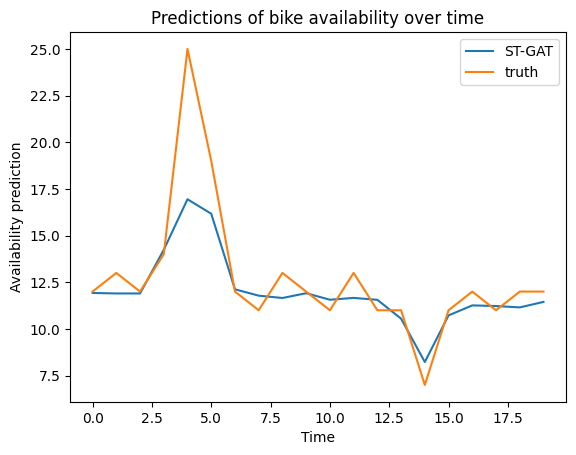

20


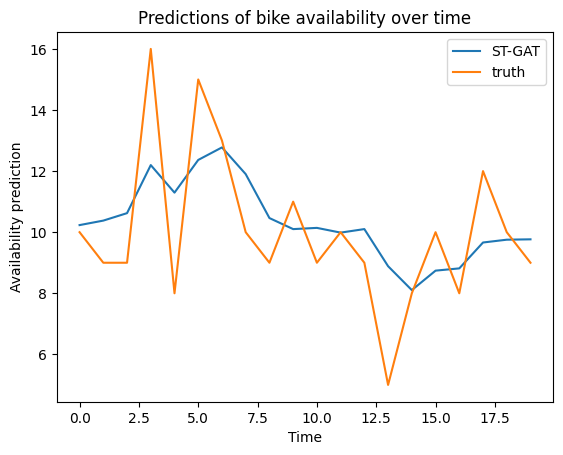

20


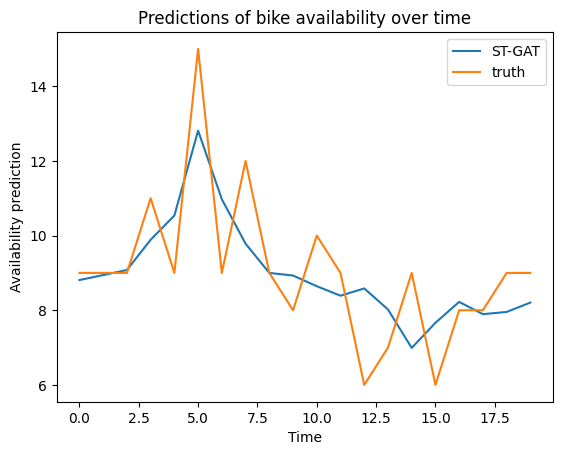

20


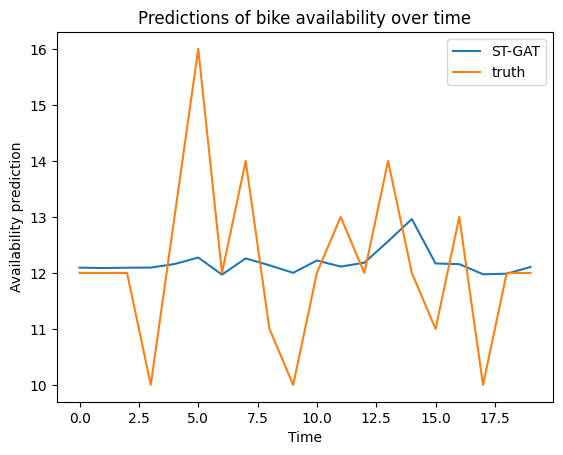

20


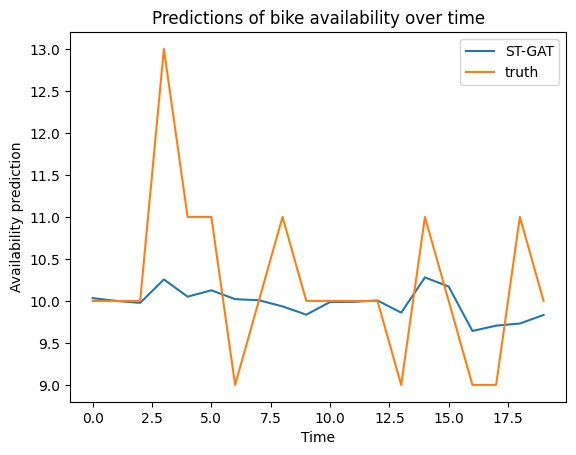

20


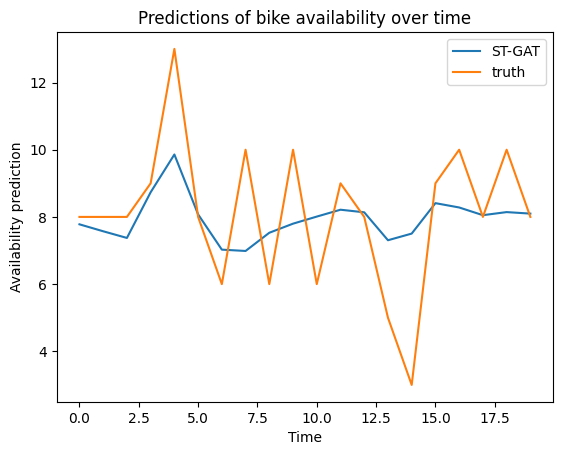

20


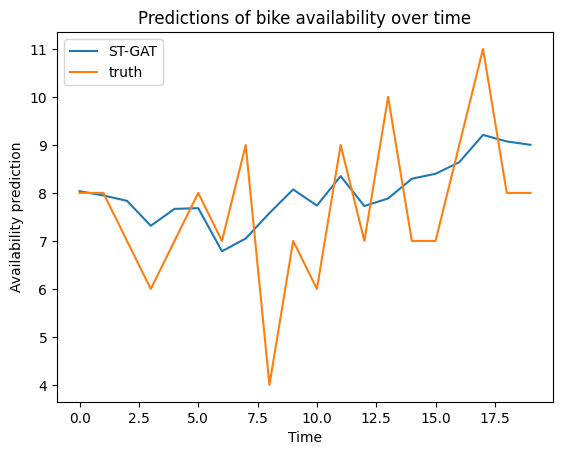

20


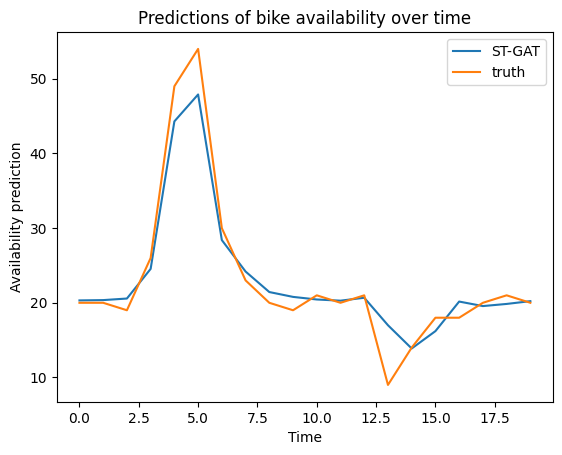

20


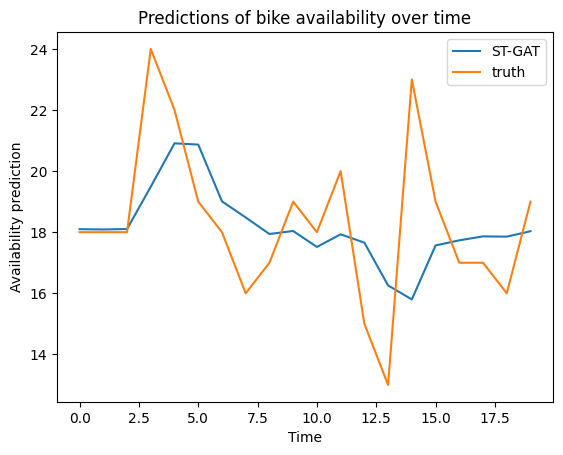

20


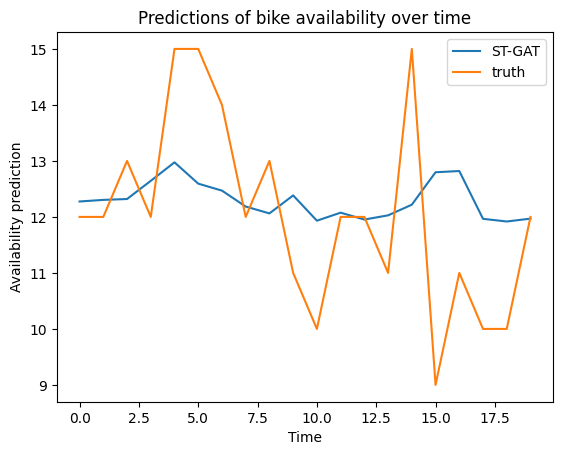

20


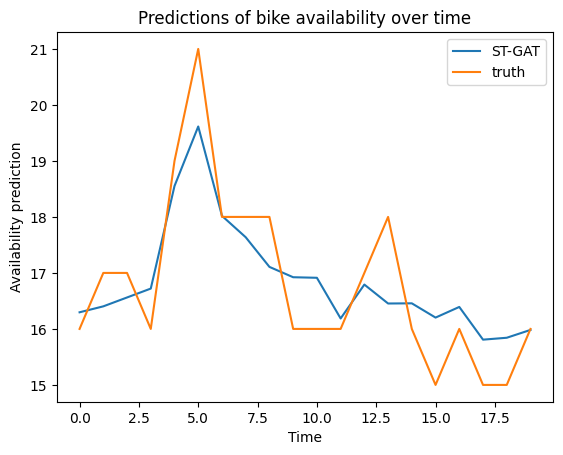

In [ ]:
temp=y_truth
temp2=y_pred
y_truth=temp
y_pred=temp2

for i in range(5,16):
  plot_prediction(y_truth,y_pred,i,config)

In [ ]:
model, train_maes, train_rmses, train_mapes, val_maes, val_rmses, val_mapes, epochs = model_train(train_dataloader, val_dataloader, config, device)

Epoch 0:   0%|          | 0/35 [00:00<?, ?it/s]<ipython-input-38-5f13822f0bc1>:63: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  x = torch.cuda.FloatTensor(x)
Epoch 0: 100%|██████████| 35/35 [00:01<00:00, 17.53it/s]


Loss: 0.218
Train, MAE: 1.064914345741272, RMSE: 1.740692377090454, MAPE: 10.475533485412598
Valid, MAE: 1.12201726436615, RMSE: 1.828772783279419, MAPE: 11.182860374450684


Epoch 1: 100%|██████████| 35/35 [00:00<00:00, 140.43it/s]


Loss: 0.070


Epoch 2: 100%|██████████| 35/35 [00:00<00:00, 136.37it/s]


Loss: 0.105


Epoch 3: 100%|██████████| 35/35 [00:00<00:00, 135.98it/s]


Loss: 0.150


Epoch 4: 100%|██████████| 35/35 [00:00<00:00, 136.36it/s]


Loss: 0.052


Epoch 5: 100%|██████████| 35/35 [00:00<00:00, 139.74it/s]


Loss: 0.053
Train, MAE: 0.5072715878486633, RMSE: 1.0097929239273071, MAPE: 5.4683966636657715
Valid, MAE: 0.6393479108810425, RMSE: 1.2295082807540894, MAPE: 7.082618713378906


Epoch 6: 100%|██████████| 35/35 [00:00<00:00, 134.49it/s]


Loss: 0.174


Epoch 7: 100%|██████████| 35/35 [00:00<00:00, 140.60it/s]


Loss: 0.046


Epoch 8: 100%|██████████| 35/35 [00:00<00:00, 141.35it/s]


Loss: 0.060


Epoch 9: 100%|██████████| 35/35 [00:00<00:00, 137.32it/s]


Loss: 0.110


Epoch 10: 100%|██████████| 35/35 [00:00<00:00, 132.66it/s]


Loss: 0.069
Train, MAE: 0.5112656354904175, RMSE: 1.0080143213272095, MAPE: 5.499143123626709
Valid, MAE: 0.6324508190155029, RMSE: 1.2818559408187866, MAPE: 6.908155918121338


Epoch 11: 100%|██████████| 35/35 [00:00<00:00, 139.89it/s]


Loss: 0.121


Epoch 12: 100%|██████████| 35/35 [00:00<00:00, 136.61it/s]


Loss: 0.064


Epoch 13: 100%|██████████| 35/35 [00:00<00:00, 137.34it/s]


Loss: 0.066


Epoch 14: 100%|██████████| 35/35 [00:00<00:00, 140.25it/s]


Loss: 0.076


Epoch 15: 100%|██████████| 35/35 [00:00<00:00, 144.05it/s]


Loss: 0.066
Train, MAE: 0.5052833557128906, RMSE: 0.9966657161712646, MAPE: 5.448044776916504
Valid, MAE: 0.64434814453125, RMSE: 1.2156752347946167, MAPE: 7.1577935218811035


Epoch 16: 100%|██████████| 35/35 [00:00<00:00, 138.78it/s]


Loss: 0.068


Epoch 17: 100%|██████████| 35/35 [00:00<00:00, 138.66it/s]


Loss: 0.073


Epoch 18: 100%|██████████| 35/35 [00:00<00:00, 140.77it/s]


Loss: 0.063


Epoch 19: 100%|██████████| 35/35 [00:00<00:00, 135.53it/s]


Loss: 0.195


Epoch 20: 100%|██████████| 35/35 [00:00<00:00, 134.57it/s]


Loss: 0.095
Train, MAE: 0.5016819834709167, RMSE: 0.9690009951591492, MAPE: 5.400611877441406
Valid, MAE: 0.5704889893531799, RMSE: 1.09353768825531, MAPE: 6.34259557723999


Epoch 21: 100%|██████████| 35/35 [00:00<00:00, 138.46it/s]


Loss: 0.100


Epoch 22: 100%|██████████| 35/35 [00:00<00:00, 119.13it/s]


Loss: 0.068


Epoch 23: 100%|██████████| 35/35 [00:00<00:00, 96.18it/s]


Loss: 0.057


Epoch 24: 100%|██████████| 35/35 [00:00<00:00, 106.08it/s]


Loss: 0.074


Epoch 25: 100%|██████████| 35/35 [00:00<00:00, 105.29it/s]


Loss: 0.065
Train, MAE: 0.48757144808769226, RMSE: 0.9515841007232666, MAPE: 5.269465923309326
Valid, MAE: 0.5612329244613647, RMSE: 1.0864030122756958, MAPE: 6.2457170486450195


Epoch 26: 100%|██████████| 35/35 [00:00<00:00, 109.78it/s]


Loss: 0.164


Epoch 27: 100%|██████████| 35/35 [00:00<00:00, 101.11it/s]


Loss: 0.101


Epoch 28: 100%|██████████| 35/35 [00:00<00:00, 101.18it/s]


Loss: 0.063


Epoch 29: 100%|██████████| 35/35 [00:00<00:00, 110.25it/s]


Loss: 0.083


Epoch 30: 100%|██████████| 35/35 [00:00<00:00, 103.67it/s]


Loss: 0.094
Train, MAE: 0.48647451400756836, RMSE: 0.9225481152534485, MAPE: 5.243558406829834
Valid, MAE: 0.5860417485237122, RMSE: 1.0953489542007446, MAPE: 6.483907222747803


Epoch 31: 100%|██████████| 35/35 [00:00<00:00, 110.08it/s]


Loss: 0.060


Epoch 32: 100%|██████████| 35/35 [00:00<00:00, 134.71it/s]


Loss: 0.065


Epoch 33: 100%|██████████| 35/35 [00:00<00:00, 140.84it/s]


Loss: 0.146


Epoch 34: 100%|██████████| 35/35 [00:00<00:00, 136.22it/s]


Loss: 0.088


Epoch 35: 100%|██████████| 35/35 [00:00<00:00, 139.27it/s]


Loss: 0.062
Train, MAE: 0.4733419716358185, RMSE: 0.8898961544036865, MAPE: 5.110966682434082
Valid, MAE: 0.5995059013366699, RMSE: 1.098565936088562, MAPE: 6.6285552978515625


Epoch 36: 100%|██████████| 35/35 [00:00<00:00, 140.60it/s]


Loss: 0.066


Epoch 37: 100%|██████████| 35/35 [00:00<00:00, 138.69it/s]


Loss: 0.061


Epoch 38: 100%|██████████| 35/35 [00:00<00:00, 136.81it/s]


Loss: 0.092


Epoch 39: 100%|██████████| 35/35 [00:00<00:00, 137.89it/s]


Loss: 0.044


Epoch 40: 100%|██████████| 35/35 [00:00<00:00, 142.04it/s]


Loss: 0.060
Train, MAE: 0.4632466435432434, RMSE: 0.8742145299911499, MAPE: 4.998837947845459
Valid, MAE: 0.6282538771629333, RMSE: 1.137338638305664, MAPE: 6.891929626464844


Epoch 41: 100%|██████████| 35/35 [00:00<00:00, 133.05it/s]


Loss: 0.072


Epoch 42: 100%|██████████| 35/35 [00:00<00:00, 139.25it/s]


Loss: 0.057


Epoch 43: 100%|██████████| 35/35 [00:00<00:00, 139.18it/s]


Loss: 0.096


Epoch 44: 100%|██████████| 35/35 [00:00<00:00, 134.67it/s]


Loss: 0.059


Epoch 45: 100%|██████████| 35/35 [00:00<00:00, 127.92it/s]


Loss: 0.050
Train, MAE: 0.4707185924053192, RMSE: 0.8734356164932251, MAPE: 5.079696178436279
Valid, MAE: 0.5907924771308899, RMSE: 1.0858176946640015, MAPE: 6.604079723358154


Epoch 46: 100%|██████████| 35/35 [00:00<00:00, 139.50it/s]


Loss: 0.036


Epoch 47: 100%|██████████| 35/35 [00:00<00:00, 143.42it/s]


Loss: 0.064


Epoch 48: 100%|██████████| 35/35 [00:00<00:00, 133.51it/s]


Loss: 0.044


Epoch 49: 100%|██████████| 35/35 [00:00<00:00, 137.75it/s]


Loss: 0.066


Epoch 50: 100%|██████████| 35/35 [00:00<00:00, 140.58it/s]


Loss: 0.066
Train, MAE: 0.45974528789520264, RMSE: 0.8641610145568848, MAPE: 4.967735767364502
Valid, MAE: 0.6075887680053711, RMSE: 1.1230605840682983, MAPE: 6.673007965087891


Epoch 51: 100%|██████████| 35/35 [00:00<00:00, 137.25it/s]


Loss: 0.080


Epoch 52: 100%|██████████| 35/35 [00:00<00:00, 143.26it/s]


Loss: 0.045


Epoch 53: 100%|██████████| 35/35 [00:00<00:00, 140.82it/s]


Loss: 0.093


Epoch 54: 100%|██████████| 35/35 [00:00<00:00, 140.24it/s]


Loss: 0.060


Epoch 55: 100%|██████████| 35/35 [00:00<00:00, 135.67it/s]


Loss: 0.071
Train, MAE: 0.4563407599925995, RMSE: 0.8553782105445862, MAPE: 4.9259257316589355
Valid, MAE: 0.5595431923866272, RMSE: 1.0588902235031128, MAPE: 6.210082054138184


Epoch 56: 100%|██████████| 35/35 [00:00<00:00, 140.32it/s]


Loss: 0.071


Epoch 57: 100%|██████████| 35/35 [00:00<00:00, 139.84it/s]


Loss: 0.045


Epoch 58: 100%|██████████| 35/35 [00:00<00:00, 136.11it/s]


Loss: 0.059


Epoch 59: 100%|██████████| 35/35 [00:00<00:00, 139.10it/s]


Loss: 0.044


Epoch 60: 100%|██████████| 35/35 [00:00<00:00, 140.97it/s]


Loss: 0.063
Train, MAE: 0.45596686005592346, RMSE: 0.8593231439590454, MAPE: 4.942999839782715
Valid, MAE: 0.5560828447341919, RMSE: 1.0404175519943237, MAPE: 6.197009563446045


Epoch 61: 100%|██████████| 35/35 [00:00<00:00, 132.00it/s]


Loss: 0.066


Epoch 62: 100%|██████████| 35/35 [00:00<00:00, 136.21it/s]


Loss: 0.059


Epoch 63: 100%|██████████| 35/35 [00:00<00:00, 139.44it/s]


Loss: 0.081


Epoch 64: 100%|██████████| 35/35 [00:00<00:00, 128.92it/s]


Loss: 0.071


Epoch 65: 100%|██████████| 35/35 [00:00<00:00, 112.98it/s]


Loss: 0.096
Train, MAE: 0.4510849714279175, RMSE: 0.8518936634063721, MAPE: 4.882772922515869
Valid, MAE: 0.5402789115905762, RMSE: 1.01151442527771, MAPE: 6.037451267242432


Epoch 66: 100%|██████████| 35/35 [00:00<00:00, 114.28it/s]


Loss: 0.066


Epoch 67: 100%|██████████| 35/35 [00:00<00:00, 103.37it/s]


Loss: 0.066


Epoch 68: 100%|██████████| 35/35 [00:00<00:00, 102.93it/s]


Loss: 0.045


Epoch 69: 100%|██████████| 35/35 [00:00<00:00, 107.46it/s]


Loss: 0.065


Epoch 70: 100%|██████████| 35/35 [00:00<00:00, 99.96it/s] 


Loss: 0.081
Train, MAE: 0.44743913412094116, RMSE: 0.845072329044342, MAPE: 4.838519096374512
Valid, MAE: 0.6609306931495667, RMSE: 1.1747684478759766, MAPE: 7.495640754699707


Epoch 71: 100%|██████████| 35/35 [00:00<00:00, 105.59it/s]


Loss: 0.052


Epoch 72: 100%|██████████| 35/35 [00:00<00:00, 102.47it/s]


Loss: 0.060


Epoch 73: 100%|██████████| 35/35 [00:00<00:00, 97.85it/s]


Loss: 0.071


Epoch 74: 100%|██████████| 35/35 [00:00<00:00, 124.98it/s]


Loss: 0.054


Epoch 75: 100%|██████████| 35/35 [00:00<00:00, 139.58it/s]


Loss: 0.038
Train, MAE: 0.4462428092956543, RMSE: 0.8463551998138428, MAPE: 4.817715167999268
Valid, MAE: 0.5627250671386719, RMSE: 1.0665221214294434, MAPE: 6.289849758148193


Epoch 76: 100%|██████████| 35/35 [00:00<00:00, 138.08it/s]


Loss: 0.036


Epoch 77: 100%|██████████| 35/35 [00:00<00:00, 138.98it/s]


Loss: 0.074


Epoch 78: 100%|██████████| 35/35 [00:00<00:00, 141.88it/s]


Loss: 0.065


Epoch 79: 100%|██████████| 35/35 [00:00<00:00, 137.74it/s]


Loss: 0.091


Epoch 80: 100%|██████████| 35/35 [00:00<00:00, 132.30it/s]


Loss: 0.057
Train, MAE: 0.4502911865711212, RMSE: 0.8463838696479797, MAPE: 4.855920791625977
Valid, MAE: 0.637139618396759, RMSE: 1.1566094160079956, MAPE: 7.107392311096191


Epoch 81: 100%|██████████| 35/35 [00:00<00:00, 140.91it/s]


Loss: 0.069


Epoch 82: 100%|██████████| 35/35 [00:00<00:00, 142.73it/s]


Loss: 0.050


Epoch 83: 100%|██████████| 35/35 [00:00<00:00, 137.06it/s]


Loss: 0.037


Epoch 84: 100%|██████████| 35/35 [00:00<00:00, 138.26it/s]


Loss: 0.042


Epoch 85: 100%|██████████| 35/35 [00:00<00:00, 135.75it/s]


Loss: 0.051
Train, MAE: 0.45361506938934326, RMSE: 0.8492896556854248, MAPE: 4.928041458129883
Valid, MAE: 0.6101095676422119, RMSE: 1.133800983428955, MAPE: 7.154225826263428


Epoch 86: 100%|██████████| 35/35 [00:00<00:00, 135.37it/s]


Loss: 0.077


Epoch 87: 100%|██████████| 35/35 [00:00<00:00, 131.01it/s]


Loss: 0.039


Epoch 88: 100%|██████████| 35/35 [00:00<00:00, 135.82it/s]


Loss: 0.053


Epoch 89: 100%|██████████| 35/35 [00:00<00:00, 139.66it/s]


Loss: 0.040


Epoch 90: 100%|██████████| 35/35 [00:00<00:00, 136.07it/s]


Loss: 0.055
Train, MAE: 0.4523356258869171, RMSE: 0.8441734313964844, MAPE: 4.89632511138916
Valid, MAE: 0.5858250856399536, RMSE: 1.0940721035003662, MAPE: 6.5933356285095215


Epoch 91: 100%|██████████| 35/35 [00:00<00:00, 139.44it/s]


Loss: 0.081


Epoch 92: 100%|██████████| 35/35 [00:00<00:00, 127.24it/s]


Loss: 0.054


Epoch 93: 100%|██████████| 35/35 [00:00<00:00, 141.38it/s]


Loss: 0.048


Epoch 94: 100%|██████████| 35/35 [00:00<00:00, 133.24it/s]


Loss: 0.061


Epoch 95: 100%|██████████| 35/35 [00:00<00:00, 133.52it/s]


Loss: 0.083
Train, MAE: 0.45731163024902344, RMSE: 0.844782292842865, MAPE: 4.9382429122924805
Valid, MAE: 0.5911171436309814, RMSE: 1.0957227945327759, MAPE: 6.513993740081787


Epoch 96: 100%|██████████| 35/35 [00:00<00:00, 140.20it/s]


Loss: 0.057


Epoch 97: 100%|██████████| 35/35 [00:00<00:00, 132.39it/s]


Loss: 0.077


Epoch 98: 100%|██████████| 35/35 [00:00<00:00, 137.08it/s]


Loss: 0.030


Epoch 99: 100%|██████████| 35/35 [00:00<00:00, 138.41it/s]


Loss: 0.073


Epoch 100: 100%|██████████| 35/35 [00:00<00:00, 138.66it/s]


Loss: 0.042
Train, MAE: 0.44394218921661377, RMSE: 0.8376720547676086, MAPE: 4.815556049346924
Valid, MAE: 0.5561560988426208, RMSE: 1.0438621044158936, MAPE: 6.128372669219971


Epoch 101: 100%|██████████| 35/35 [00:00<00:00, 138.21it/s]


Loss: 0.063


Epoch 102: 100%|██████████| 35/35 [00:00<00:00, 139.12it/s]


Loss: 0.042


Epoch 103: 100%|██████████| 35/35 [00:00<00:00, 138.05it/s]


Loss: 0.052


Epoch 104: 100%|██████████| 35/35 [00:00<00:00, 132.92it/s]


Loss: 0.097


Epoch 105: 100%|██████████| 35/35 [00:00<00:00, 136.29it/s]


Loss: 0.054
Train, MAE: 0.44762036204338074, RMSE: 0.8311224579811096, MAPE: 4.831267833709717
Valid, MAE: 0.521090030670166, RMSE: 0.9547412991523743, MAPE: 5.781132698059082


Epoch 106: 100%|██████████| 35/35 [00:00<00:00, 133.16it/s]


Loss: 0.094


Epoch 107: 100%|██████████| 35/35 [00:00<00:00, 99.00it/s]


Loss: 0.040


Epoch 108: 100%|██████████| 35/35 [00:00<00:00, 82.98it/s]


Loss: 0.064


Epoch 109: 100%|██████████| 35/35 [00:00<00:00, 88.20it/s]


Loss: 0.057


Epoch 110: 100%|██████████| 35/35 [00:00<00:00, 89.51it/s]


Loss: 0.103
Train, MAE: 0.44496840238571167, RMSE: 0.8328873515129089, MAPE: 4.8101420402526855
Valid, MAE: 0.6383843421936035, RMSE: 1.1583364009857178, MAPE: 7.06123685836792


Epoch 111: 100%|██████████| 35/35 [00:00<00:00, 79.43it/s]


Loss: 0.073


Epoch 112: 100%|██████████| 35/35 [00:00<00:00, 84.35it/s]


Loss: 0.086


Epoch 113: 100%|██████████| 35/35 [00:00<00:00, 90.83it/s]


Loss: 0.045


Epoch 114: 100%|██████████| 35/35 [00:00<00:00, 90.61it/s]


Loss: 0.061


Epoch 115: 100%|██████████| 35/35 [00:00<00:00, 80.64it/s]


Loss: 0.098
Train, MAE: 0.44348305463790894, RMSE: 0.8288517594337463, MAPE: 4.790520668029785
Valid, MAE: 0.5783836245536804, RMSE: 1.0721055269241333, MAPE: 6.421792030334473


Epoch 116: 100%|██████████| 35/35 [00:00<00:00, 89.80it/s]


Loss: 0.038


Epoch 117: 100%|██████████| 35/35 [00:00<00:00, 83.61it/s]


Loss: 0.049


Epoch 118: 100%|██████████| 35/35 [00:00<00:00, 80.59it/s]


Loss: 0.073


Epoch 119: 100%|██████████| 35/35 [00:00<00:00, 78.77it/s]


Loss: 0.058


Epoch 120: 100%|██████████| 35/35 [00:00<00:00, 81.47it/s]


Loss: 0.046
Train, MAE: 0.44305357336997986, RMSE: 0.8309261798858643, MAPE: 4.78506326675415
Valid, MAE: 0.6267773509025574, RMSE: 1.1473444700241089, MAPE: 7.407786846160889


Epoch 121: 100%|██████████| 35/35 [00:00<00:00, 83.24it/s]


Loss: 0.064


Epoch 122: 100%|██████████| 35/35 [00:00<00:00, 84.34it/s]


Loss: 0.059


Epoch 123: 100%|██████████| 35/35 [00:00<00:00, 129.03it/s]


Loss: 0.051


Epoch 124: 100%|██████████| 35/35 [00:00<00:00, 140.36it/s]


Loss: 0.037


Epoch 125: 100%|██████████| 35/35 [00:00<00:00, 134.46it/s]


Loss: 0.068
Train, MAE: 0.43976515531539917, RMSE: 0.8258591294288635, MAPE: 4.752665996551514
Valid, MAE: 0.5588868856430054, RMSE: 1.0390969514846802, MAPE: 6.17153787612915


Epoch 126: 100%|██████████| 35/35 [00:00<00:00, 136.96it/s]


Loss: 0.091


Epoch 127: 100%|██████████| 35/35 [00:00<00:00, 135.94it/s]


Loss: 0.090


Epoch 128: 100%|██████████| 35/35 [00:00<00:00, 137.14it/s]


Loss: 0.038


Epoch 129: 100%|██████████| 35/35 [00:00<00:00, 133.10it/s]


Loss: 0.060


Epoch 130: 100%|██████████| 35/35 [00:00<00:00, 142.73it/s]


Loss: 0.052
Train, MAE: 0.43883877992630005, RMSE: 0.82757967710495, MAPE: 4.748088359832764
Valid, MAE: 0.6042665243148804, RMSE: 1.114328384399414, MAPE: 6.778628826141357


Epoch 131: 100%|██████████| 35/35 [00:00<00:00, 139.84it/s]


Loss: 0.054


Epoch 132: 100%|██████████| 35/35 [00:00<00:00, 133.76it/s]


Loss: 0.048


Epoch 133: 100%|██████████| 35/35 [00:00<00:00, 139.73it/s]


Loss: 0.076


Epoch 134: 100%|██████████| 35/35 [00:00<00:00, 139.32it/s]


Loss: 0.046


Epoch 135: 100%|██████████| 35/35 [00:00<00:00, 137.73it/s]


Loss: 0.043
Train, MAE: 0.4378291964530945, RMSE: 0.824278712272644, MAPE: 4.740114212036133
Valid, MAE: 0.6506024599075317, RMSE: 1.1637096405029297, MAPE: 7.360899448394775


Epoch 136: 100%|██████████| 35/35 [00:00<00:00, 137.21it/s]


Loss: 0.055


Epoch 137: 100%|██████████| 35/35 [00:00<00:00, 139.91it/s]


Loss: 0.076


Epoch 138: 100%|██████████| 35/35 [00:00<00:00, 137.99it/s]


Loss: 0.039


Epoch 139: 100%|██████████| 35/35 [00:00<00:00, 138.83it/s]


Loss: 0.071


Epoch 140: 100%|██████████| 35/35 [00:00<00:00, 137.48it/s]


Loss: 0.085
Train, MAE: 0.44144585728645325, RMSE: 0.8237168192863464, MAPE: 4.764036178588867
Valid, MAE: 0.5810695290565491, RMSE: 1.076931118965149, MAPE: 6.479988098144531


Epoch 141: 100%|██████████| 35/35 [00:00<00:00, 139.75it/s]


Loss: 0.077


Epoch 142: 100%|██████████| 35/35 [00:00<00:00, 140.09it/s]


Loss: 0.073


Epoch 143: 100%|██████████| 35/35 [00:00<00:00, 133.41it/s]


Loss: 0.055


Epoch 144: 100%|██████████| 35/35 [00:00<00:00, 142.45it/s]


Loss: 0.078


Epoch 145: 100%|██████████| 35/35 [00:00<00:00, 136.15it/s]


Loss: 0.080
Train, MAE: 0.4367653429508209, RMSE: 0.8222922682762146, MAPE: 4.727521896362305
Valid, MAE: 0.5622786283493042, RMSE: 1.0632073879241943, MAPE: 6.293746471405029


Epoch 146: 100%|██████████| 35/35 [00:00<00:00, 134.81it/s]


Loss: 0.064


Epoch 147: 100%|██████████| 35/35 [00:00<00:00, 138.97it/s]


Loss: 0.046


Epoch 148: 100%|██████████| 35/35 [00:00<00:00, 138.92it/s]


Loss: 0.066


Epoch 149: 100%|██████████| 35/35 [00:00<00:00, 139.29it/s]


Loss: 0.046


Epoch 150: 100%|██████████| 35/35 [00:00<00:00, 133.98it/s]


Loss: 0.043
Train, MAE: 0.4326319992542267, RMSE: 0.8170021772384644, MAPE: 4.675904750823975
Valid, MAE: 0.6182377934455872, RMSE: 1.1300715208053589, MAPE: 6.957025051116943


Epoch 151: 100%|██████████| 35/35 [00:00<00:00, 140.00it/s]


Loss: 0.028


Epoch 152: 100%|██████████| 35/35 [00:00<00:00, 129.00it/s]


Loss: 0.043


Epoch 153: 100%|██████████| 35/35 [00:00<00:00, 134.85it/s]


Loss: 0.047


Epoch 154: 100%|██████████| 35/35 [00:00<00:00, 139.14it/s]


Loss: 0.084


Epoch 155: 100%|██████████| 35/35 [00:00<00:00, 136.20it/s]


Loss: 0.027
Train, MAE: 0.436280757188797, RMSE: 0.8213047981262207, MAPE: 4.722500324249268
Valid, MAE: 0.6516554951667786, RMSE: 1.160815954208374, MAPE: 7.393179416656494


Epoch 156: 100%|██████████| 35/35 [00:00<00:00, 103.24it/s]


Loss: 0.095


Epoch 157: 100%|██████████| 35/35 [00:00<00:00, 100.83it/s]


Loss: 0.065


Epoch 158: 100%|██████████| 35/35 [00:00<00:00, 107.67it/s]


Loss: 0.048


Epoch 159: 100%|██████████| 35/35 [00:00<00:00, 100.43it/s]


Loss: 0.054


Epoch 160: 100%|██████████| 35/35 [00:00<00:00, 106.42it/s]


Loss: 0.038
Train, MAE: 0.4392455518245697, RMSE: 0.8213198184967041, MAPE: 4.750308990478516
Valid, MAE: 0.654150128364563, RMSE: 1.157250165939331, MAPE: 7.172092437744141


Epoch 161: 100%|██████████| 35/35 [00:00<00:00, 98.92it/s]


Loss: 0.058


Epoch 162: 100%|██████████| 35/35 [00:00<00:00, 102.82it/s]


Loss: 0.108


Epoch 163: 100%|██████████| 35/35 [00:00<00:00, 105.43it/s]


Loss: 0.067


Epoch 164: 100%|██████████| 35/35 [00:00<00:00, 97.70it/s]


Loss: 0.046


Epoch 165: 100%|██████████| 35/35 [00:00<00:00, 104.05it/s]


Loss: 0.048
Train, MAE: 0.43541619181632996, RMSE: 0.8197621703147888, MAPE: 4.717135429382324
Valid, MAE: 0.5490007400512695, RMSE: 1.0271297693252563, MAPE: 6.064097881317139


Epoch 166: 100%|██████████| 35/35 [00:00<00:00, 138.43it/s]


Loss: 0.072


Epoch 167: 100%|██████████| 35/35 [00:00<00:00, 133.26it/s]


Loss: 0.064


Epoch 168: 100%|██████████| 35/35 [00:00<00:00, 137.93it/s]


Loss: 0.070


Epoch 169: 100%|██████████| 35/35 [00:00<00:00, 137.93it/s]


Loss: 0.071


Epoch 170: 100%|██████████| 35/35 [00:00<00:00, 140.48it/s]


Loss: 0.049
Train, MAE: 0.4336099624633789, RMSE: 0.8192984461784363, MAPE: 4.703040599822998
Valid, MAE: 0.5828895568847656, RMSE: 1.0945966243743896, MAPE: 6.5308756828308105


Epoch 171: 100%|██████████| 35/35 [00:00<00:00, 142.82it/s]


Loss: 0.030


Epoch 172: 100%|██████████| 35/35 [00:00<00:00, 134.86it/s]


Loss: 0.072


Epoch 173: 100%|██████████| 35/35 [00:00<00:00, 123.87it/s]


Loss: 0.045


Epoch 174: 100%|██████████| 35/35 [00:00<00:00, 132.75it/s]


Loss: 0.060


Epoch 175: 100%|██████████| 35/35 [00:00<00:00, 129.69it/s]


Loss: 0.047
Train, MAE: 0.4356295168399811, RMSE: 0.81828373670578, MAPE: 4.7121710777282715
Valid, MAE: 0.5768126845359802, RMSE: 1.0520848035812378, MAPE: 6.3665361404418945


Epoch 176: 100%|██████████| 35/35 [00:00<00:00, 126.99it/s]


Loss: 0.066


Epoch 177: 100%|██████████| 35/35 [00:00<00:00, 130.60it/s]


Loss: 0.075


Epoch 178: 100%|██████████| 35/35 [00:00<00:00, 134.99it/s]


Loss: 0.080


Epoch 179: 100%|██████████| 35/35 [00:00<00:00, 135.42it/s]


Loss: 0.065


Epoch 180: 100%|██████████| 35/35 [00:00<00:00, 134.79it/s]


Loss: 0.091
Train, MAE: 0.4347841441631317, RMSE: 0.8160361051559448, MAPE: 4.696061611175537
Valid, MAE: 0.5564444661140442, RMSE: 1.0424212217330933, MAPE: 6.236786842346191


Epoch 181: 100%|██████████| 35/35 [00:00<00:00, 139.44it/s]


Loss: 0.044


Epoch 182: 100%|██████████| 35/35 [00:00<00:00, 132.00it/s]


Loss: 0.053


Epoch 183: 100%|██████████| 35/35 [00:00<00:00, 137.54it/s]


Loss: 0.065


Epoch 184: 100%|██████████| 35/35 [00:00<00:00, 128.46it/s]


Loss: 0.056


Epoch 185: 100%|██████████| 35/35 [00:00<00:00, 134.56it/s]


Loss: 0.046
Train, MAE: 0.4347569942474365, RMSE: 0.8160315752029419, MAPE: 4.705451965332031
Valid, MAE: 0.5841615200042725, RMSE: 1.0638704299926758, MAPE: 6.4986114501953125


Epoch 186: 100%|██████████| 35/35 [00:00<00:00, 134.18it/s]


Loss: 0.068


Epoch 187: 100%|██████████| 35/35 [00:00<00:00, 129.67it/s]


Loss: 0.036


Epoch 188: 100%|██████████| 35/35 [00:00<00:00, 135.43it/s]


Loss: 0.045


Epoch 189: 100%|██████████| 35/35 [00:00<00:00, 138.52it/s]


Loss: 0.098


Epoch 190: 100%|██████████| 35/35 [00:00<00:00, 139.11it/s]


Loss: 0.063
Train, MAE: 0.4321554899215698, RMSE: 0.8163825273513794, MAPE: 4.676899433135986
Valid, MAE: 0.5131020545959473, RMSE: 0.9759423136711121, MAPE: 5.729576110839844


Epoch 191: 100%|██████████| 35/35 [00:00<00:00, 136.95it/s]


Loss: 0.062


Epoch 192: 100%|██████████| 35/35 [00:00<00:00, 134.21it/s]


Loss: 0.054


Epoch 193: 100%|██████████| 35/35 [00:00<00:00, 136.17it/s]


Loss: 0.031


Epoch 194: 100%|██████████| 35/35 [00:00<00:00, 134.94it/s]


Loss: 0.059


Epoch 195: 100%|██████████| 35/35 [00:00<00:00, 134.50it/s]


Loss: 0.059
Train, MAE: 0.43897393345832825, RMSE: 0.8160414695739746, MAPE: 4.755339622497559
Valid, MAE: 0.5509412884712219, RMSE: 1.0351976156234741, MAPE: 6.224828243255615


Epoch 196: 100%|██████████| 35/35 [00:00<00:00, 138.28it/s]


Loss: 0.041


Epoch 197: 100%|██████████| 35/35 [00:00<00:00, 138.84it/s]


Loss: 0.043


Epoch 198: 100%|██████████| 35/35 [00:00<00:00, 110.16it/s]


Loss: 0.066


Epoch 199: 100%|██████████| 35/35 [00:00<00:00, 106.45it/s]

Loss: 0.043


In [ ]:
rmse, mae, mape, y_pred, y_truth = model_test(model, test_dataloader, device, config)

Test, MAE: 0.5120798349380493, RMSE: 0.9653571248054504, MAPE: 5.692458629608154


22


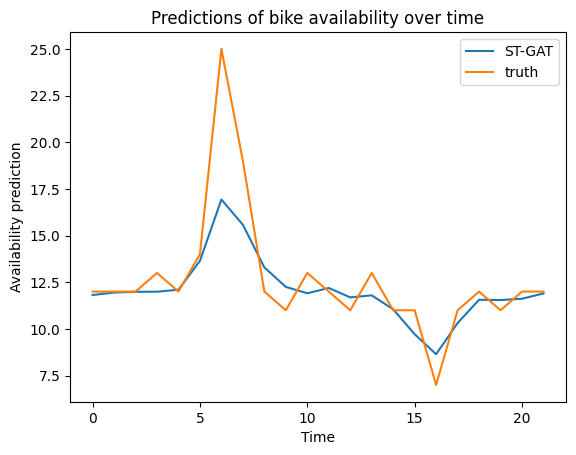

22


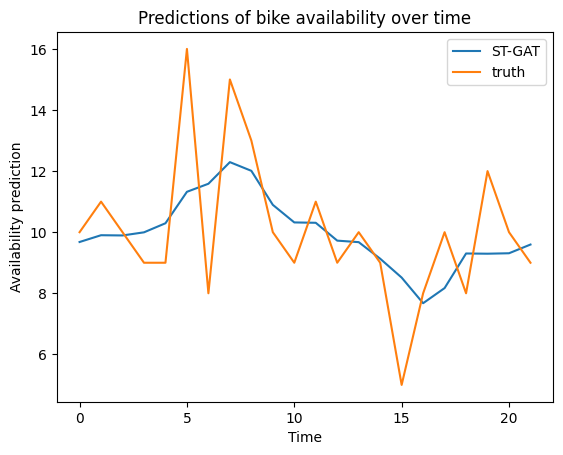

22


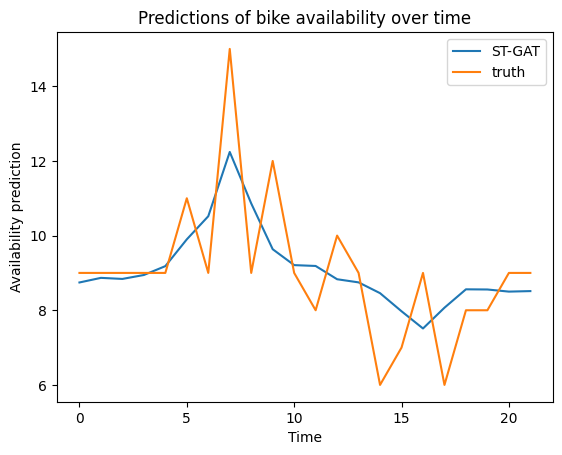

22


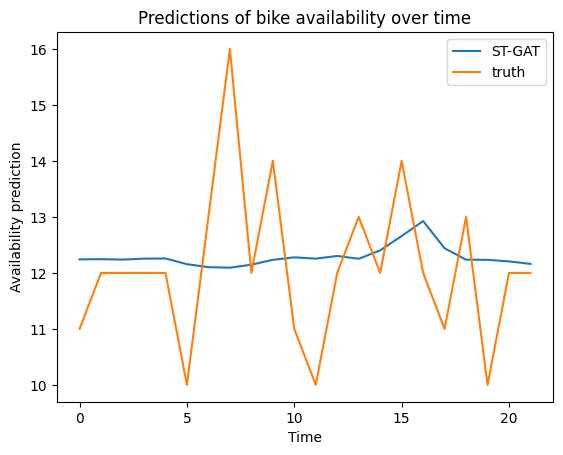

22


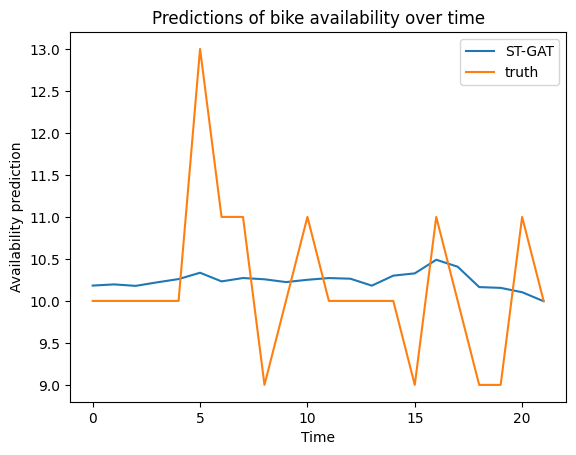

22


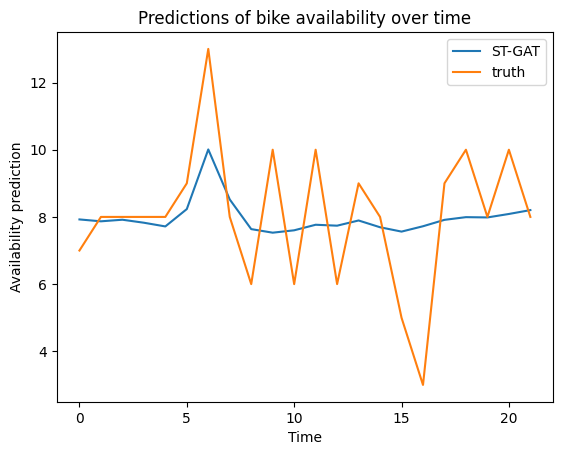

22


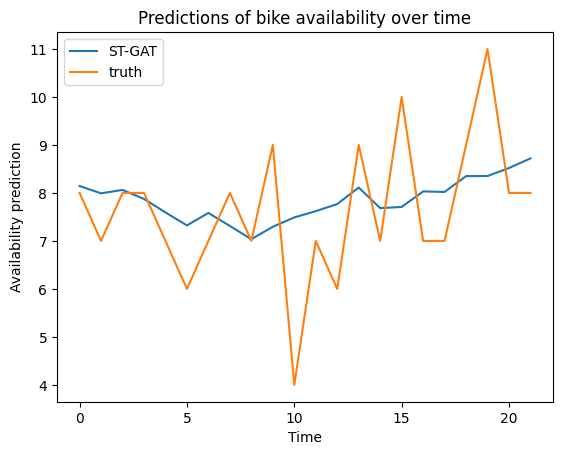

22


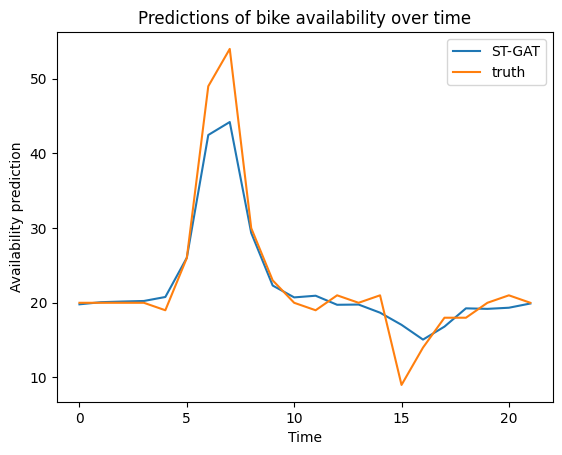

22


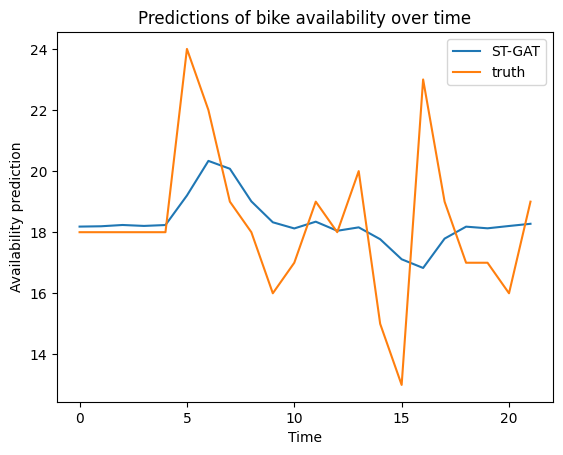

22


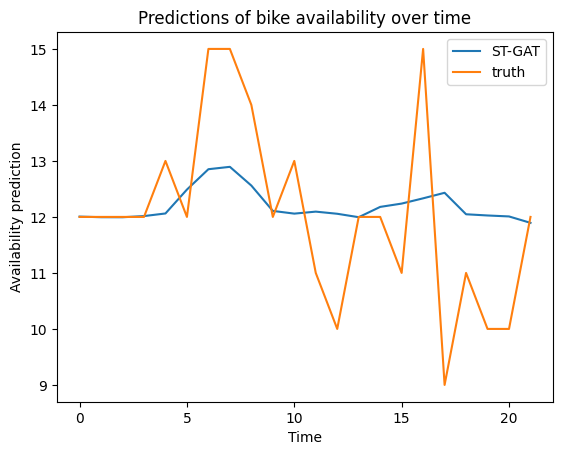

22


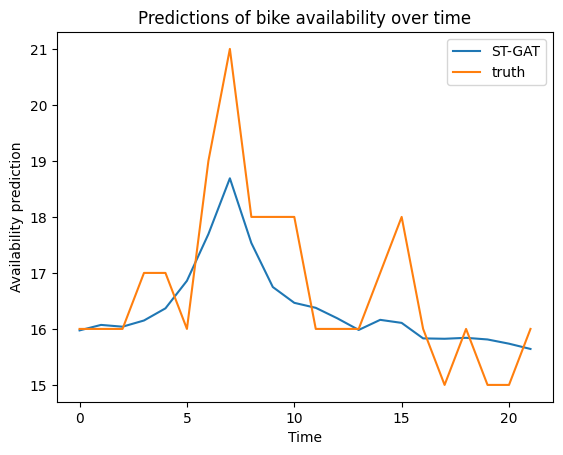

In [ ]:
temp=y_truth
temp2=y_pred
y_truth=temp
y_pred=temp2

for i in range(5,16):
  plot_prediction(y_truth,y_pred,i,config)